In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from nba_api.stats.endpoints import playercareerstats
import time
from nba_api.stats.endpoints import leaguegamelog
import pandas as pd

def get_season_schedule(season):
    
    call_season = leaguegamelog.LeagueGameLog(season=season)
    season = pd.concat(call_season.get_data_frames())
    
    season['home_game'] = season['MATCHUP'].apply(lambda x : False if (x.find('@') != -1) else True)
    
    return season
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import boxscoretraditionalv2
import time

def player_data_for_game(game_id, team_ids):
    
    # get boxscore for game
    call_boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)
    boxscore = pd.concat(call_boxscore.get_data_frames())
    
    # get players listed for this game
    players_game = boxscore['PLAYER_ID'].drop_duplicates().dropna()
    
    # init list of player data
    list_player = list()
    
    # loop over theses players to get their career stats
    for player in players_game:
        
        print(player)
        call_player = playercareerstats.PlayerCareerStats(player_id=str(int(player)), per_mode36="PerGame")
        
        # clean the returned
        tmp = carrer_stats_clean(pd.concat(call_player.get_data_frames()))
        
        # append to list
        list_player.append(tmp)
        
        # sleep to don't overstress - set as parameter in code later, to fine tune wait times more easily
        time.sleep(1)
        
    return pd.concat(list_player), boxscore

from nba_api.stats.endpoints import boxscoretraditionalv2
import time

def boxscores_for_team(team_id, season_obj):
    
    # get the ids of all the games our team has played
    team_game_ids = season_obj[season_obj['TEAM_ID'] == team_id]
    
    # subset to those games
    bool_matchups = season_obj['GAME_ID'].isin(team_game_ids['GAME_ID'])
    team_season = season_obj[bool_matchups]
    
    # get the unique game ids for the teams season
    game_ids = team_season['GAME_ID'].unique()
    
    # init the boxscore list
    boxscore = list()
    
    # loop over those games
    for game in game_ids:
        
        # get boxscore for game
        call_boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game)
        boxscore.append(pd.concat(call_boxscore.get_data_frames()))
        
        # sleep and print
        time.sleep(0.5)
        print(game)
    
    # create full dataframe
    team_boxscores = pd.concat(boxscore)
    
    # subset, such that only the starting fives are left (simplification)
    bool_startingfive = ((team_boxscores['START_POSITION'] == "G")|(team_boxscores['START_POSITION'] == "F")|(team_boxscores['START_POSITION'] == "C"))
    boxscore_startingfive = team_boxscores[bool_startingfive]
    
    return team_season, boxscore_startingfive

from nba_api.stats.static import teams
from nba_api.stats.endpoints import playercareerstats
def player_ability(team_boxscores, team_id):
    
    starting_fives = team_boxscores[team_boxscores['TEAM_ID'] == team_id]['PLAYER_ID'].unique()
    list_player = list()

    for starter in starting_fives:
        call_player = playercareerstats.PlayerCareerStats(player_id=str(int(starter)), per_mode36="PerGame")

        # clean the returned
        df = pd.concat(call_player.get_data_frames())
    
        # get array of all team ids
        nba_teams = pd.DataFrame(teams.get_teams())
        team_ids = np.unique(nba_teams['id'])

        # columns to drop
        drop_list = ["Team_ID", "ORGANIZATION_ID", "SCHOOL_NAME", "RANK_PG_MIN", "RANK_PG_FGM", "RANK_PG_FGA",
                 "RANK_FG_PCT", "RANK_PG_FG3M", "RANK_PG_FG3A", "RANK_FG3_PCT", "RANK_PG_FTM", "RANK_PG_FTA",
                "RANK_FT_PCT", "RANK_PG_OREB", "RANK_PG_DREB", "RANK_PG_REB", "RANK_PG_AST", "RANK_PG_STL",
                "RANK_PG_BLK", "RANK_PG_TOV", "RANK_PG_PTS", "RANK_PG_EFF"]

        # ids of the nba teams - removes all-star appearances
        bool_nbateam = df['TEAM_ID'].isin(team_ids)

        # drop cols
        df = df.loc[:, ['PLAYER_ID', 'SEASON_ID', 'TEAM_ID', 'PLAYER_AGE', 'GP', 
                        'GS', 'MIN', 'FG_PCT', 'FGA', 'FG3_PCT', 'FG3A', 'FT_PCT', 'FTA', 'OREB', 'DREB', 'REB',
                       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]

        # remove all "other teams" e.g. all-star and totals
        df = df[bool_nbateam]

        # drop na's
        df = df.dropna()

        # keep first observations - what exactly are those?
        tmp = df[~df.index.duplicated(keep='first')]

        # append to list
        list_player.append(tmp)

        time.sleep(0.5)
        print(starter)

    # return dataframe
    return pd.concat(list_player)

def aggregate_stats(player_stats):
    
    # switch out creation for later procedure
    aggregate_player = player_stats.groupby("PLAYER_ID").mean()['MIN']
    
    # return in good shape and rename
    tmp = pd.DataFrame(aggregate_player)
    tmp = tmp.reset_index()
    
    return tmp.rename(columns={"MIN": "ability_MIN"})
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playercareerstats
import numpy as np
import pandas as pd

def get_carrer_stats_clean(player_id):
    
    # api call
    call_player = playercareerstats.PlayerCareerStats(player_id=player_id, per_mode36="PerGame")
    df = pd.concat(call_player.get_data_frames())
    
    # get array of all team ids
    nba_teams = pd.DataFrame(teams.get_teams())
    team_ids = np.unique(nba_teams['id'])
    
    # columns to drop
    drop_list = ["Team_ID", "ORGANIZATION_ID", "SCHOOL_NAME", "RANK_PG_MIN", "RANK_PG_FGM", "RANK_PG_FGA",
             "RANK_FG_PCT", "RANK_PG_FG3M", "RANK_PG_FG3A", "RANK_FG3_PCT", "RANK_PG_FTM", "RANK_PG_FTA",
            "RANK_FT_PCT", "RANK_PG_OREB", "RANK_PG_DREB", "RANK_PG_REB", "RANK_PG_AST", "RANK_PG_STL",
            "RANK_PG_BLK", "RANK_PG_TOV", "RANK_PG_PTS", "RANK_PG_EFF"]
    
    # ids of the nba teams - removes all-star appearances
    bool_nbateam = df['TEAM_ID'].isin(team_ids)
    
    # drop cols
    df = df.loc[:, ['PLAYER_ID', 'SEASON_ID', 'TEAM_ID', 'PLAYER_AGE', 'GP', 
                    'GS', 'MIN', 'FG_PCT', 'FGA', 'FG3_PCT', 'FG3A', 'FT_PCT', 'FTA', 'OREB', 'DREB', 'REB',
                   'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
    
    # remove all "other teams" e.g. all-star and totals
    df = df[bool_nbateam]
    
    # drop na's
    df = df.dropna()
    
    # keep first observations - what exactly are those?
    df = df[~df.index.duplicated(keep='first')]

    return df

In [303]:
scores = pd.read_csv("FourFactorsRAPM.csv", delimiter=",", skiprows=1)
scores = scores.reset_index().drop(['index'], axis=1)
seasons_subset = ['2020-21', '2019-20', '2018-19', '2017-18', '2016-17']
seasons = [22020, 22019, 22018, 22017, 22016]
scores = scores[scores['season'].isin(seasons_subset)]

In [304]:
# rename for merging
scores.loc[scores['season'] == "2020-21",'season'] = 22020
scores.loc[scores['season'] == "2019-20",'season'] = 22019
scores.loc[scores['season'] == "2018-19",'season'] = 22018
scores.loc[scores['season'] == "2017-18",'season'] = 22017
scores.loc[scores['season'] == "2016-17",'season'] = 22016

In [305]:
df_schedule, df_boxscores = pd.read_csv("./data/season_prediction/schedule.csv"), pd.read_csv("./data/season_prediction/boxscores.csv")

In [306]:
# select seasons
#seasons = [22020, 22019]
df_schedule = df_schedule[df_schedule['SEASON_ID'].isin(seasons)]

games = df_schedule['GAME_ID'].unique()
df_boxscores = df_boxscores[df_boxscores['GAME_ID'].isin(games)]

# merge schedule and boxscores
df = pd.merge(df_schedule, df_boxscores, how='left', on=["GAME_ID", 'TEAM_ID'], suffixes=("_team", "_player"))
df['home_game'] = df['MATCHUP'].apply(lambda x: x.find('@') == -1)

# merge scores and df
#df = pd.merge(df, scores, how='left', left_on=['PLAYER_ID', 'SEASON_ID'], right_on=['playerId', 'season'])

In [307]:
df

,Unnamed: 0_team,Unnamed: 0.1_team,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,WL,...,PACE,PACE_PER40,POSS,PIE,TEAM_NAME_player,E_TM_TOV_PCT,Unnamed: 0.1.1,player_game_index,len_game_id,home_game
0,0,0,22016,1610612739,CLE,Cleveland Cavaliers,21600001,2016-10-25,CLE vs. NYK,W,...,102.27,85.23,69,0.282,NaN,NaN,NaN,NaN,21600001,True
1,0,0,22016,1610612739,CLE,Cleveland Cavaliers,21600001,2016-10-25,CLE vs. NYK,W,...,105.67,88.06,55,0.344,NaN,NaN,NaN,NaN,21600001,True
2,0,0,22016,1610612739,CLE,Cleveland Cavaliers,21600001,2016-10-25,CLE vs. NYK,W,...,102.82,85.68,48,-0.026,NaN,NaN,NaN,NaN,21600001,True
3,0,0,22016,1610612739,CLE,Cleveland Cavaliers,21600001,2016-10-25,CLE vs. NYK,W,...,100.82,84.02,53,0.036,NaN,NaN,NaN,NaN,21600001,True
4,0,0,22016,1610612739,CLE,Cleveland Cavaliers,21600001,2016-10-25,CLE vs. NYK,W,...,98.25,81.87,61,0.219,NaN,NaN,NaN,NaN,21600001,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160402,2159,2159,22020,1610612740,NOP,New Orleans Pelicans,22001072,2021-05-16,NOP vs. LAL,L,...,101.07,84.22,54,0.152,NaN,NaN,31013.0,31013.0,22001072,True
160403,2159,2159,22020,1610612740,NOP,New Orleans Pelicans,22001072,2021-05-16,NOP vs. LAL,L,...,106.72,88.94,14,0.000,NaN,NaN,31014.0,31014.0,22001072,True
160404,2159,2159,22020,1610612740,NOP,New Orleans Pelicans,22001072,2021-05-16,NOP vs. LAL,L,...,NaN,NaN,0,NaN,NaN,NaN,31015.0,31015.0,22001072,True
160405,2159,2159,22020,1610612740,NOP,New Orleans Pelicans,22001072,2021-05-16,NOP vs. LAL,L,...,NaN,NaN,0,NaN,NaN,NaN,31016.0,31016.0,22001072,True


In [9]:
from sklearn.model_selection import train_test_split
import itertools

# select seasons
seasons = [22020, 22019]
df_schedule = df_schedule[df_schedule['SEASON_ID'].isin(seasons)]

games = df_schedule['GAME_ID'].unique()
df_boxscores = df_boxscores[df_boxscores['GAME_ID'].isin(games)]

# merge schedule and boxscores
df = pd.merge(df_schedule, df_boxscores, how='left', on=["GAME_ID", 'TEAM_ID'], suffixes=("_team", "_player"))
df['home_game'] = df['MATCHUP'].apply(lambda x: x.find('@') == -1)

# merge scores and df
df = pd.merge(df, scores, how='left', left_on=['PLAYER_ID', 'SEASON_ID'], right_on=['playerId', 'season'])

# create sixth man
sixth_man = pd.DataFrame(df[df['START_POSITION'].isna()].groupby(['TEAM_ID', 'GAME_ID'])['RAPM'].aggregate('mean')).reset_index().drop_duplicates()
sixth_man['START_POSITION'] = "SIXTH_MAN"
df_sixth = pd.merge(sixth_man, df[['GAME_ID', 'TEAM_ID', 'home_game']], on=['GAME_ID', 'TEAM_ID'])
df_sixth = df_sixth.drop_duplicates()

# calculate bench depth
df['BENCH'] = df['START_POSITION'].isna()
bench_depth = pd.DataFrame(df.groupby(['GAME_ID', 'TEAM_ID'])['BENCH'].sum()).reset_index().drop_duplicates()
bench_depth = bench_depth.rename(columns={'BENCH':'BENCH_DEPTH'})
df = pd.merge(df, bench_depth, how='left')

# mark bench depth
df.loc[df['home_game'], 'BENCH_DEPTH_TEAM'] = 'BENCH_DEPTH_HOME'
df.loc[~df['home_game'], 'BENCH_DEPTH_TEAM'] = 'BENCH_DEPTH_AWAY'

# append to dataframe
df = df.append(df_sixth)

# filter for Starters only
df = df[~df['START_POSITION'].isna()]
df2 = df

# create counts
half = int(df.shape[0] / 2)
repetitions_half = int(half / 6)

# first step for role player variable
sixth_home = ['SIXTH_HOME_1'] * repetitions_half
guard_home = ['GUARD_HOME_1', 'GUARD_HOME_2'] * repetitions_half
forward_home = ['FORWARD_HOME_1', 'FORWARD_HOME_2'] * repetitions_half
center_home = ['CENTER_HOME_1'] * repetitions_half

sixth_away = ['SIXTH_AWAY_1'] * repetitions_half
guard_away = ['GUARD_AWAY_1', 'GUARD_AWAY_2'] * repetitions_half
forward_away = ['FORWARD_AWAY_1', 'FORWARD_AWAY_2'] * repetitions_half
center_away = ['CENTER_AWAY_1'] * repetitions_half

# create player role
player_role = list(itertools.chain(sixth_home, guard_home, forward_home, center_home, 
                                   sixth_away, guard_away, forward_away, center_away))

# sort values and insert the player role
df = df.sort_values(['home_game', 'START_POSITION'], ascending=False)
df['PLAYER_COURT_ROLE'] = np.asarray(player_role)

#### return df ####


# subset dataframes
df_sub = df[['PLUS_MINUS', 'home_game', 'TEAM_ID','TEAM_ABBREVIATION_team','GAME_ID', 'PLAYER_ID', 'playerName', 'PLAYER_COURT_ROLE', 'RAPM', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']]
df_reg = df_sub[['PLUS_MINUS', 'home_game', 'TEAM_ID','GAME_ID', 'PLAYER_ID', 'PLAYER_COURT_ROLE', 'RAPM', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']]

sub_bench = df_reg[['GAME_ID', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']].drop_duplicates()
sub_bench = sub_bench.pivot('GAME_ID', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH').reset_index()

# create df model frame
df_reg_scores = df_reg[['GAME_ID', 'PLUS_MINUS', 'home_game']]
wide = df_reg.pivot('GAME_ID', 'PLAYER_COURT_ROLE', 'RAPM').reset_index()
df_model = pd.merge(wide, df_reg_scores)
df_model = pd.merge(df_model, sub_bench, how='left', on='GAME_ID')

df_interpretation = df_model[['GAME_ID', 'home_game', 'GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1', 'BENCH_DEPTH_AWAY', 'PLUS_MINUS']]
df_model = df_model[['home_game', 'GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1', 'BENCH_DEPTH_AWAY', 'PLUS_MINUS']]

# drop duplicates and keep only observations from HT perspective
df_model = df_model.drop_duplicates()
df_model = df_model.dropna()
df_model = df_model[df_model['home_game']]

df_interpretation = df_interpretation.drop_duplicates()
df_interpretation = df_interpretation.dropna()
df_interpretation = df_interpretation[df_interpretation['home_game']]

# merge back to schedule for interpretation
df_interpretation = pd.merge(df_schedule, df_interpretation, left_on="GAME_ID", right_on="GAME_ID", how='right')
df_interpretation = df_interpretation[df_interpretation['is_home_game']]

# seperate into labels and features
y = df_model['PLUS_MINUS'].to_numpy()
features_names = ['GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1', 'BENCH_DEPTH_AWAY']
X = df_model[features_names].to_numpy()

# get bool for na rows
na_rows = ~np.isnan(X).any(axis=1)

# remove na rows
X = X[na_rows]
y = y[na_rows]

# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# games of first season / training season
n_games = 1060

# season split
X_train, X_test, y_train, y_test = X[0:n_games], X[n_games:], y[0:n_games], y[n_games:]

# keep track of real games
df_int_train = df_interpretation.iloc[0:n_games,]
df_int_test = df_interpretation.iloc[n_games:,]

In [402]:
import itertools

def preprocess_season_data(schedule, boxscores, seasons: list):
    """ create preprocessed dataframe from schedule and boxscores
    """
    # init variables
    df_schedule = schedule
    df_boxscores = boxscores
    
    # select seasons
    df_schedule = df_schedule[df_schedule['SEASON_ID'].isin(seasons)]

    games = df_schedule['GAME_ID'].unique()
    df_boxscores = df_boxscores[df_boxscores['GAME_ID'].isin(games)]

    # merge schedule and boxscores
    df = pd.merge(df_schedule, df_boxscores, how='left', on=["GAME_ID", 'TEAM_ID'], suffixes=("_team", "_player"))
    df['home_game'] = df['MATCHUP'].apply(lambda x: x.find('@') == -1)

    # merge scores and df
    df = pd.merge(df, scores, how='left', left_on=['PLAYER_ID', 'SEASON_ID'], right_on=['playerId', 'season'])

    # create sixth man
    sixth_man = pd.DataFrame(df[df['START_POSITION'].isna()].groupby(['TEAM_ID', 'GAME_ID'])['RAPM'].aggregate('mean')).reset_index().drop_duplicates()
    sixth_man['START_POSITION'] = "SIXTH_MAN"
    df_sixth = pd.merge(sixth_man, df[['GAME_ID', 'TEAM_ID', 'home_game']], on=['GAME_ID', 'TEAM_ID'])
    df_sixth = df_sixth.drop_duplicates()

    # calculate bench depth
    df['BENCH'] = df['START_POSITION'].isna()
    bench_depth = pd.DataFrame(df.groupby(['GAME_ID', 'TEAM_ID'])['BENCH'].sum()).reset_index().drop_duplicates()
    bench_depth = bench_depth.rename(columns={'BENCH':'BENCH_DEPTH'})
    df = pd.merge(df, bench_depth, how='left')

    # mark bench depth
    df.loc[df['home_game'], 'BENCH_DEPTH_TEAM'] = 'BENCH_DEPTH_HOME'
    df.loc[~df['home_game'], 'BENCH_DEPTH_TEAM'] = 'BENCH_DEPTH_AWAY'

    # append to dataframe
    df = df.append(df_sixth)

    # filter for Starters only
    df = df[~df['START_POSITION'].isna()]
    df2 = df

    # create counts
    half = int(df.shape[0] / 2)
    repetitions_half = int(half / 6)

    # first step for role player variable
    sixth_home = ['SIXTH_HOME_1'] * repetitions_half
    guard_home = ['GUARD_HOME_1', 'GUARD_HOME_2'] * repetitions_half
    forward_home = ['FORWARD_HOME_1', 'FORWARD_HOME_2'] * repetitions_half
    center_home = ['CENTER_HOME_1'] * repetitions_half

    sixth_away = ['SIXTH_AWAY_1'] * repetitions_half
    guard_away = ['GUARD_AWAY_1', 'GUARD_AWAY_2'] * repetitions_half
    forward_away = ['FORWARD_AWAY_1', 'FORWARD_AWAY_2'] * repetitions_half
    center_away = ['CENTER_AWAY_1'] * repetitions_half

    # create player role
    player_role = list(itertools.chain(sixth_home, guard_home, forward_home, center_home, 
                                       sixth_away, guard_away, forward_away, center_away))

    # sort values and insert the player role
    df = df.sort_values(['home_game', 'START_POSITION'], ascending=False)
    df['PLAYER_COURT_ROLE'] = np.asarray(player_role)
    
    # quick and dirty nan fill
    df = df.sort_values('GAME_ID')
    df['SEASON_ID'] = df['SEASON_ID'].ffill()
    df['SEASON_ID'] = df['SEASON_ID'].bfill()
    
    df = df.sort_values(['SEASON_ID', 'GAME_ID'])
    
    return df

In [403]:
def trade_player_function(player_in, player_out, df, scores):
    """
    
    :param df: dataframe, merged schedule and boxscores - already existing RAPM column
    :param scores: dataframe, containt mapping from playerid and seasonid to performance score
    """
    
    # player in, player out id
    player_in = 2544
    player_out = 203939

    # get name
    player_in_name = df[df['PLAYER_ID'] == player_in]['PLAYER_NAME'].values[0]
    player_out_name = df[df['PLAYER_ID'] == player_out]['PLAYER_NAME'].values[0]
    
    # get team of "out" player i.e. our team
    out_team_id = df[df['PLAYER_ID'] == player_out]['TEAM_ID'].unique()[-1]
    in_team_id = df[df['PLAYER_ID'] == player_in]['TEAM_ID'].unique()[-1]

    # copy the dataframe
    df2 = df.copy()

    # get performance scores - be careful with the respective season!
    recent_rapm_in = scores[scores['playerId'] == player_in].sort_values('season', ascending=False)['RAPM'].values[0]
    recent_rapm_out = scores[scores['playerId'] == player_out].sort_values('season', ascending=False)['RAPM'].values[0]

    # sub in the player_in
    df2['PLAYER_OUT_ID'] = df2['PLAYER_ID']
    df2.loc[df['PLAYER_ID'] == player_out, 'PLAYER_ID'] = player_in
    df2.loc[df['PLAYER_ID'] == player_out, 'RAPM'] = recent_rapm_in
    df2.loc[df['PLAYER_ID'] == player_out, 'PLAYER_NAME'] = player_in_name

    # transfer player_out to player_in's former team
    df2.loc[df2['PLAYER_OUT_ID'] == player_in, 'PLAYER_ID'] = player_out
    df2.loc[df2['PLAYER_OUT_ID'] == player_in, 'RAPM'] = recent_rapm_out
    df2.loc[df2['PLAYER_OUT_ID'] == player_in, 'PLAYER_NAME'] = player_out_name

    return df2, out_team_id, in_team_id

In [540]:
def get_model_data(df):
    """
    """
    # subset dataframes
    df_sub = df[['PLUS_MINUS', 'home_game', 'TEAM_ID','TEAM_ABBREVIATION_team','GAME_ID', 'SEASON_ID', 'PLAYER_ID', 'playerName', 'PLAYER_COURT_ROLE', 'RAPM', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']]
    df_reg = df_sub[['PLUS_MINUS', 'home_game', 'TEAM_ID','GAME_ID', 'SEASON_ID', 'PLAYER_ID', 'PLAYER_COURT_ROLE', 'RAPM', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']]

    sub_bench = df_reg[['GAME_ID', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']].drop_duplicates()
    sub_bench = sub_bench.pivot('GAME_ID', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH').reset_index()

    # create df model frame
    df_reg_scores = df_reg[['GAME_ID', 'PLUS_MINUS', 'home_game']]
    wide = df_reg.pivot(['GAME_ID', 'SEASON_ID'], 'PLAYER_COURT_ROLE', 'RAPM').reset_index()
    df_model = pd.merge(wide, df_reg_scores)
    df_model = pd.merge(df_model, sub_bench, how='left', on='GAME_ID')

    df_interpretation = df_model[['GAME_ID', 'SEASON_ID', 'home_game', 'GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1', 'BENCH_DEPTH_AWAY', 'PLUS_MINUS']]
    df_model = df_model[['SEASON_ID','GAME_ID', 'home_game', 'GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1', 'BENCH_DEPTH_AWAY', 'PLUS_MINUS']]

    # drop duplicates and keep only observations from HT perspective
    df_model = df_model.drop_duplicates()
    df_model = df_model.dropna()
    df_model = df_model[df_model['home_game']]
    
    df_interpretation = df_interpretation.drop_duplicates()
    df_interpretation = df_interpretation.dropna()
    df_interpretation = df_interpretation[df_interpretation['home_game']]

    # merge back to schedule for interpretation
    df_interpretation = pd.merge(df_schedule, df_interpretation, left_on="GAME_ID", right_on="GAME_ID", how='right')
    df_interpretation = df_interpretation[df_interpretation['is_home_game']]
    df_interpretation = df_interpretation.drop_duplicates()
    
    # get home and away team
    df_interpretation['HOME_TEAM_ABB'] = df_interpretation['MATCHUP'].apply(lambda x: x[0:3])
    df_interpretation['AWAY_TEAM_ABB'] = df_interpretation['MATCHUP'].apply(lambda x: x[-3:])
    
    return df_model.sort_values(['SEASON_ID', 'GAME_ID']), df_interpretation.sort_values(['SEASON_ID_x', 'GAME_ID'])

In [541]:
def get_train_season_games(df, last_train_season):
    """ helper function to get n_games for subset
    
    :param last_train_season: enter in 22016 format
    """
    train_seasons = np.arange(22016, last_train_season + 1)
    n_games = df[df['SEASON_ID'].isin(train_seasons)].shape[0]
    
    return int(n_games / 12)

In [542]:
def get_train_test_set(df_model, df_interpretation, n_games):
    """
    """
    
    df_model_train = df_model[0:n_games]
    df_model_test = df_model[n_games:]
    
    # seperate into labels and features
    y = df_model['PLUS_MINUS'].to_numpy()
    features_names = ['GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1', 'BENCH_DEPTH_AWAY']
    X = df_model[features_names].to_numpy()

    # get bool for na rows
    na_rows = ~np.isnan(X).any(axis=1)

    # remove na rows
    X = X[na_rows]
    y = y[na_rows]

    # train, test split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # season split
    X_train, X_test, y_train, y_test = X[0:n_games], X[n_games:], y[0:n_games], y[n_games:]
    
    # keep track of real games
    df_int_train = df_interpretation.iloc[0:n_games,]
    df_int_test = df_interpretation.iloc[n_games:,]
    
    return X_train, y_train, X_test, y_test, df_int_train, df_int_test, df_model_train, df_model_test

Function that counts out the wins per team!

In [543]:
# standard training, test set
df3 = preprocess_season_data(schedule=df_schedule, boxscores=df_boxscores, seasons = seasons)
n_games = get_train_season_games(df3, last_train_season=22019)
df_model, df_int = get_model_data(df=df3)
X_train, y_train, X_test, y_test, df_int_train, df_int_test, df_model_train, df_model_test = get_train_test_set(df_model=df_model, df_interpretation=df_int, n_games=n_games)

In [544]:
df_int

,Unnamed: 0,Unnamed: 0.1,SEASON_ID_x,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,GUARD_AWAY_1,GUARD_AWAY_2,FORWARD_AWAY_1,FORWARD_AWAY_2,CENTER_AWAY_1,SIXTH_AWAY_1,BENCH_DEPTH_AWAY,PLUS_MINUS_y,HOME_TEAM_ABB,AWAY_TEAM_ABB
0,0,0,22016,1610612739,CLE,Cleveland Cavaliers,21600001,2016-10-25,CLE vs. NYK,W,...,-0.70,-0.08,-1.07,0.24,-0.96,-0.373750,9.0,29.0,CLE,NYK
2,4,4,22016,1610612757,POR,Portland Trail Blazers,21600002,2016-10-25,POR vs. UTA,W,...,0.13,1.82,0.47,-1.06,3.39,0.182500,9.0,9.0,POR,UTA
4,2,2,22016,1610612744,GSW,Golden State Warriors,21600003,2016-10-25,GSW vs. SAS,L,...,1.40,0.66,2.50,1.08,0.51,0.747500,9.0,-29.0,GSW,SAS
7,15,15,22016,1610612753,ORL,Orlando Magic,21600004,2016-10-26,ORL vs. MIA,L,...,1.15,0.27,0.08,0.01,0.86,-0.155000,9.0,-12.0,ORL,MIA
8,18,18,22016,1610612754,IND,Indiana Pacers,21600005,2016-10-26,IND vs. DAL,W,...,-0.52,-0.41,-0.16,0.22,-0.19,-0.388750,9.0,9.0,IND,DAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11646,2142,2142,22020,1610612757,POR,Portland Trail Blazers,22001076,2021-05-16,POR vs. DEN,W,...,0.22,-0.06,2.59,1.12,1.77,-0.524444,10.0,16.0,POR,DEN
11648,2148,2148,22020,1610612758,SAC,Sacramento Kings,22001077,2021-05-16,SAC vs. UTA,L,...,2.51,3.62,1.33,3.03,4.51,-0.307000,11.0,-22.0,SAC,UTA
11651,2135,2135,22020,1610612759,SAS,San Antonio Spurs,22001078,2021-05-16,SAS vs. PHX,L,...,-0.04,1.59,1.95,-0.27,2.30,0.253750,9.0,-2.0,SAS,PHX
11653,2155,2155,22020,1610612761,TOR,Toronto Raptors,22001079,2021-05-16,TOR vs. IND,L,...,0.23,0.14,-0.61,0.89,-0.52,0.430000,8.0,-12.0,TOR,IND


In [545]:
df_int['MATCHUP'].apply(lambda x: x[-3:])

0        NYK
2        UTA
4        SAS
7        MIA
8        DAL
        ... 
11646    DEN
11648    UTA
11651    PHX
11653    IND
11654    CHA
Name: MATCHUP, Length: 5828, dtype: object

In [546]:
y_train[0:30]

array([ 29.,   9., -29., -12.,   9.,   5.,  18., -11.,   4.,  -5.,  -6.,
       -19.,   6.,  15.,   6.,  -8.,  -8.,  -3.,   9.,  26.,   3.,  -6.,
        -8.,   7.,  -8., -32.,  -6.,   7.,   6.,  17.])

In [547]:
df_model

,SEASON_ID,GAME_ID,home_game,GUARD_HOME_1,GUARD_HOME_2,FORWARD_HOME_1,FORWARD_HOME_2,CENTER_HOME_1,SIXTH_HOME_1,BENCH_DEPTH_HOME,GUARD_AWAY_1,GUARD_AWAY_2,FORWARD_AWAY_1,FORWARD_AWAY_2,CENTER_AWAY_1,SIXTH_AWAY_1,BENCH_DEPTH_AWAY,PLUS_MINUS
1,22016.0,21600001,True,-0.30,1.91,3.90,2.66,0.14,-0.338750,9.0,-0.70,-0.08,-1.07,0.24,-0.96,-0.373750,9.0,29.0
15,22016.0,21600002,True,0.95,1.13,1.53,0.74,0.49,-0.641250,9.0,0.13,1.82,0.47,-1.06,3.39,0.182500,9.0,9.0
26,22016.0,21600003,True,2.99,5.33,2.72,3.56,1.92,0.052500,9.0,1.40,0.66,2.50,1.08,0.51,0.747500,9.0,-29.0
36,22016.0,21600004,True,-0.52,0.50,0.67,-0.28,-0.46,-1.536250,9.0,1.15,0.27,0.08,0.01,0.86,-0.155000,9.0,-12.0
48,22016.0,21600005,True,-0.17,0.31,1.72,0.65,1.13,-0.766250,9.0,-0.52,-0.41,-0.16,0.22,-0.19,-0.388750,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69902,22020.0,22001076,True,1.58,1.49,0.39,1.81,1.18,-0.270000,11.0,0.22,-0.06,2.59,1.12,1.77,-0.524444,10.0,16.0
69912,22020.0,22001077,True,0.45,-0.02,0.12,-0.61,-0.76,-0.430000,8.0,2.51,3.62,1.33,3.03,4.51,-0.307000,11.0,-22.0
69928,22020.0,22001078,True,-2.33,1.94,-0.85,-1.72,1.27,-0.370000,9.0,-0.04,1.59,1.95,-0.27,2.30,0.253750,9.0,-2.0
69940,22020.0,22001079,True,0.90,-1.54,-1.94,-0.98,-0.11,-0.502857,8.0,0.23,0.14,-0.61,0.89,-0.52,0.430000,8.0,-12.0


In [548]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# estimate ridge
ridge = Ridge(alpha=1e-3)
ridge.fit(X_train, y_train)

# estimate OLS
ols = LinearRegression()
ols.fit(X_train, y_train)

# estiamte RF
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=200)
rf.fit(X_train, y_train)

# test set scores
pred_rf = regr.predict(X_test)
pred_ols = ols.predict(X_test)
pred_ridge = ridge.predict(X_test)

trade_ols = ols.predict(X_trade)

ols.score(X_test, y_test), ridge.score(X_test, y_test), rf.score(X_test, y_test)

(0.22896360530274273, 0.22896361608103755, 0.2062717177555622)

In [549]:
prediction = rf.predict(X_test)
df_int_test['Prediction_PM'] = prediction

<ipython-input-549-527513b61a2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int_test['Prediction_PM'] = prediction


In [1055]:
df_trade, out_team_id, in_team_id = trade_player_function(player_in=2544 , player_out=202704, df=df3, scores=scores)

n_games = get_train_season_games(df3, last_train_season=22019)
df_model_trade, df_int_trade = get_model_data(df=df_trade)
_, _, X_trade, _, _, _, _, df_model_test_trade = get_train_test_set(df_model=df_model_trade, df_interpretation=df_int_trade, n_games=n_games)

In [551]:
prediction = rf.predict(X_trade)
df_int_test['Prediction_Trade_PM'] = prediction

<ipython-input-551-d9c17acd0675>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int_test['Prediction_Trade_PM'] = prediction


In [553]:
df_int_test['WIN_HOME'] = np.where(df_int_test['PLUS_MINUS_y'] > 0, 1, 0)
df_int_test['WIN_AWAY'] = np.where(df_int_test['PLUS_MINUS_y'] > 0, 0, 1)
df_int_test['WIN_HOME_pred'] = np.where(df_int_test['Prediction_PM'] > 0, 1, 0)
df_int_test['WIN_AWAY_pred'] = np.where(df_int_test['Prediction_PM'] > 0, 0, 1)
df_int_test['WIN_HOME_trade'] = np.where(df_int_test['Prediction_Trade_PM'] > 0, 1, 0)
df_int_test['WIN_AWAY_trade'] = np.where(df_int_test['Prediction_Trade_PM'] > 0, 0, 1)

<ipython-input-553-17ac881e2256>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int_test['WIN_HOME'] = np.where(df_int_test['PLUS_MINUS_y'] > 0, 1, 0)
<ipython-input-553-17ac881e2256>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int_test['WIN_AWAY'] = np.where(df_int_test['PLUS_MINUS_y'] > 0, 0, 1)
<ipython-input-553-17ac881e2256>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [556]:
season_performance_home = df_int_test.groupby(['SEASON_ID_x', 'HOME_TEAM_ABB'])[['WIN_HOME', 'WIN_HOME_pred', 'WIN_HOME_trade']].sum()
season_performance_away = df_int_test.groupby(['SEASON_ID_x', 'AWAY_TEAM_ABB'])[['WIN_AWAY', 'WIN_AWAY_pred', 'WIN_AWAY_trade']].sum()
season_performance_home.reset_index(inplace=True)
season_performance_away.reset_index(inplace=True)

season_performance_tmp = pd.merge(season_performance_home, season_performance_away, left_on=['SEASON_ID_x', 'HOME_TEAM_ABB'], right_on=['SEASON_ID_x', 'AWAY_TEAM_ABB'])

In [602]:
season_performance_tmp['WIN'] = season_performance_tmp['WIN_HOME'] + season_performance_tmp['WIN_AWAY']
season_performance_tmp['WIN_pred'] = season_performance_tmp['WIN_HOME_pred'] + season_performance_tmp['WIN_AWAY_pred']
season_performance_tmp['WIN_trade'] = season_performance_tmp['WIN_HOME_trade'] + season_performance_tmp['WIN_AWAY_trade']
season_performance_tmp['TEAM_ABBREVIATION'] = season_performance_tmp['HOME_TEAM_ABB']

season_performance_tmp['TRADE_CHANGE'] = season_performance_tmp['WIN_trade'] - season_performance_tmp['WIN_pred']

season_performance = season_performance_tmp.drop(['HOME_TEAM_ABB', 'AWAY_TEAM_ABB', 'WIN_HOME', 'WIN_HOME_pred', 'WIN_HOME_trade', 'WIN_AWAY', 'WIN_AWAY_pred', 'WIN_AWAY_trade'], axis=1)

season_performance['RANK'] = season_performance['WIN'].astype(int).rank(ascending=False)
season_performance['RANK_pred'] = season_performance['WIN_pred'].astype(int).rank(ascending=False)
season_performance['RANK_trade'] = season_performance['WIN_trade'].astype(int).rank(ascending=False)

season_performance = season_performance.sort_values(['SEASON_ID_x', 'RANK'], ascending=True)

In [604]:
season_performance['TRADE_CHANGE'].sum()

0

Get Ids of home and away team and then do two seperate aggregatations, merge and add up

In [531]:
season_performance

WIN_HOME  WIN_AWAY  WIN_HOME_pred  \
SEASON_ID_x TEAM_NAME                                                   
22020       Atlanta Hawks                 25        11             30   
            Boston Celtics                21        15             32   
            Brooklyn Nets                 27         8             29   
            Charlotte Hornets             18        18             18   
            Chicago Bulls                 15        21             19   
            Cleveland Cavaliers           13        23              1   
            Dallas Mavericks              21        15             28   
            Denver Nuggets                25        11             31   
            Detroit Pistons               13        23              8   
            Golden State Warriors         25        11             23   
            Houston Rockets                9        27              3   
            Indiana Pacers                13        23             26   
            LA Clippers                   26        10             34   
            Los Angeles Lakers            21        15             30   
            Memphis Grizzlies             18        18             32   
            Miami Heat                    21        15             30   
            Milwaukee Bucks               26        10             35   
            Minnesota Timberwolves        13        23             10   
            New Orleans Pelicans          18        18             20   
            New York Knicks               25        11             30   
            Oklahoma City Thunder         10        26              7   
            Orlando Magic                 11        25              9   
            Philadelphia 76ers            29         7             34   
            Phoenix Suns                  27         9             35   
            Portland Trail Blazers        20        16             32   
            Sacramento Kings              16        20             24   
            San Antonio Spurs             14        22             16   
            Toronto Raptors               16        20             23   
            Utah Jazz                     31         5             36   
            Washington Wizards            19        17             19   

                                    WIN_AWAY_pred  WIN_HOME_trade  \
SEASON_ID_x TEAM_NAME                                               
22020       Atlanta Hawks                       6              30   
            Boston Celtics                      4              32   
            Brooklyn Nets                       6              29   
            Charlotte Hornets                  18              18   
            Chicago Bulls                      17              19   
            Cleveland Cavaliers                35               1   
            Dallas Mavericks                    8              28   
            Denver Nuggets                      5              31   
            Detroit Pistons                    28               8   
            Golden State Warriors              13              24   
            Houston Rockets                    33               3   
            Indiana Pacers                     10              27   
            LA Clippers                         2              34   
            Los Angeles Lakers                  6              29   
            Memphis Grizzlies                   4              32   
            Miami Heat                          6              30   
            Milwaukee Bucks                     1              35   
            Minnesota Timberwolves             26              10   
            New Orleans Pelicans               16              20   
            New York Knicks                     6              30   
            Oklahoma City Thunder              29               7   
            Orlando Magic                      27               9   
            Philadelphia 76ers             

In [82]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [83]:
df_model

,home_game,GUARD_HOME_1,GUARD_HOME_2,FORWARD_HOME_1,FORWARD_HOME_2,CENTER_HOME_1,SIXTH_HOME_1,BENCH_DEPTH_HOME,GUARD_AWAY_1,GUARD_AWAY_2,FORWARD_AWAY_1,FORWARD_AWAY_2,CENTER_AWAY_1,SIXTH_AWAY_1,BENCH_DEPTH_AWAY,PLUS_MINUS
1,True,1.29,0.93,1.35,2.49,2.22,0.573750,9.0,-0.23,0.23,1.48,-0.54,1.67,-0.562500,9.0,8.0
13,True,-0.29,2.39,4.32,-0.29,1.80,0.178750,9.0,1.29,1.63,0.60,3.50,0.88,0.387500,9.0,10.0
25,True,-0.89,-2.22,-2.04,-0.53,-1.76,-0.313750,9.0,-1.35,-0.26,0.50,-0.47,0.43,-0.233750,9.0,1.0
37,True,-0.58,0.80,1.03,1.24,-0.27,0.055000,9.0,-0.80,1.29,-1.48,-1.82,-1.19,-0.147500,9.0,-9.0
49,True,-0.03,1.19,0.77,0.01,1.13,-0.267500,9.0,-1.35,-1.75,-1.04,-0.95,-1.50,-0.410000,8.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25609,True,1.58,1.49,0.39,1.81,1.18,-0.270000,11.0,0.22,-0.06,2.59,1.12,1.77,-0.524444,10.0,16.0
25621,True,0.45,-0.02,0.12,-0.61,-0.76,-0.430000,8.0,2.51,3.62,1.33,3.03,4.51,-0.307000,11.0,-22.0
25633,True,-2.33,1.94,-0.85,-1.72,1.27,-0.370000,9.0,-0.04,1.59,1.95,-0.27,2.30,0.253750,9.0,-2.0
25645,True,0.90,-1.54,-1.94,-0.98,-0.11,-0.502857,8.0,0.23,0.14,-0.61,0.89,-0.52,0.430000,8.0,-12.0


In [964]:
def wrapper_trade(player_in, player_out, df, scores):

    df_trade, out_team_id, in_team_id = trade_player_function(player_in=player_in, player_out=player_out, df=df, scores=scores)
    n_games = get_train_season_games(df3, last_train_season=22019)
    df_model_trade, df_int_trade = get_model_data(df=df_trade)
    _, _, X_trade, _, _, _, _, df_model_test_trade = get_train_test_set(df_model=df_model_trade, df_interpretation=df_int_trade, n_games=n_games)
    
    return df_model_test_trade

In [1040]:
df_model_test_trade2 = wrapper_trade(player_in=2544 , player_out=202704, df=df3, scores=scores)

In [1021]:
model = bmb.Model("PLUS_MINUS ~ GUARD_HOME_1 + GUARD_HOME_2 + FORWARD_HOME_1 + FORWARD_HOME_2 + CENTER_HOME_1 + GUARD_AWAY_1 + GUARD_AWAY_2 + FORWARD_AWAY_1 + FORWARD_AWAY_2 + CENTER_AWAY_1 + SIXTH_HOME_1 + SIXTH_AWAY_1 + BENCH_DEPTH_HOME + BENCH_DEPTH_AWAY", df_model_train)
fitted = model.fit(tune=200, draws=2000, init="adapt_diag", random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PLUS_MINUS_sigma, Intercept, BENCH_DEPTH_AWAY, BENCH_DEPTH_HOME, SIXTH_AWAY_1, SIXTH_HOME_1, CENTER_AWAY_1, FORWARD_AWAY_2, FORWARD_AWAY_1, GUARD_AWAY_2, GUARD_AWAY_1, CENTER_HOME_1, FORWARD_HOME_2, FORWARD_HOME_1, GUARD_HOME_2, GUARD_HOME_1]


Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 50 seconds.
The acceptance probability does not match the target. It is 0.92463936102927, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9144864504714155, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9144226074538288, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9164285177730188, but should be close to 0.8. Try to increase the number of tuning steps.


In [1056]:
prediction = model.predict(idata=fitted, data=df_model_test, draws=100, inplace=False)
prediction_trade = model.predict(idata=fitted, data=df_model_test_trade, draws=100, inplace=False)

In [1057]:
mean_plus_minus_pred = np.mean(np.vstack(prediction.posterior['PLUS_MINUS_mean'].values), axis=0)
mean_plus_minus_trade = np.mean(np.vstack(prediction_trade.posterior['PLUS_MINUS_mean'].values), axis=0)

In [1039]:
test = mean_plus_minus_trade

In [1058]:
np.all(mean_plus_minus_trade == test)

True

In [1024]:
sigma_plus_minus_pred = np.mean(np.vstack(prediction.posterior['PLUS_MINUS_sigma'].values))
sigma_plus_minus_trade = np.mean(np.vstack(prediction_trade.posterior['PLUS_MINUS_sigma'].values))

In [1025]:
sigma_pred_mat = np.repeat(sigma_plus_minus_pred, mean_plus_minus_pred.shape[0])
sigma_trade_mat = np.repeat(sigma_plus_minus_trade, mean_plus_minus_trade.shape[0])

In [1026]:
def simulate_one_season(mean_predicted, sigma_predicted, n_sim, all_games: bool=True):
    """ optionally returns all simulation of every game - to draw histograms
    """
    
    # parameters
    n_games = mean_predicted.shape[0]

    # repeat sigma
    sigma_pred_mat = np.repeat(sigma_predicted, n_games)

    # standard normal, then shift and stretch
    all_games_sim = np.random.normal(size=(n_games, n_sim)) * sigma_pred_mat[:,None] + mean_predicted[:,None]
    
    # simulate one season
    one_season_sim = np.apply_along_axis(np.random.choice, 1, all_games_sim)
    
    if all_games:
        return one_season_sim, all_games_sim
    
    else:
        return one_season_sim

In [1027]:
n_sim = 1000

In [1028]:
one_season, season_sim = simulate_one_season(mean_predicted=mean_plus_minus_pred, sigma_predicted=sigma_plus_minus_pred, n_sim=n_sim)

In [1029]:
from tqdm import tqdm

# cout out ht and at wins
ht_wins = np.where(season_sim > 0, 1, 0)
at_wins = np.where(season_sim > 0, 0, 1)

# setup loop
histories = np.arange(n_sim)
list_history = list()

for h in tqdm(histories):

    # select one history
    df_int_test['ht_wins'] = ht_wins[:, h]
    df_int_test['at_wins'] = at_wins[:, h]

    # create scoreboard
    ht_perf = df_int_test.groupby(['SEASON_ID_x', 'HOME_TEAM_ABB'])[['ht_wins']].sum().reset_index()
    at_perf = df_int_test.groupby(['SEASON_ID_x', 'AWAY_TEAM_ABB'])[['at_wins']].sum().reset_index()

    # merge
    perf = pd.merge(ht_perf, at_perf, left_on=['SEASON_ID_x', 'HOME_TEAM_ABB'], right_on=['SEASON_ID_x', 'AWAY_TEAM_ABB'])
    perf['WINS'] = perf['ht_wins'] + perf['at_wins']
    perf = perf.drop(['HOME_TEAM_ABB', 'ht_wins', 'at_wins'], axis=1)
    perf = perf.sort_values('WINS', ascending=False)
    
    # create rank
    perf['RANK'] = perf['WINS'].rank(ascending=False)
    
    # store history number
    perf['HISTORY'] = h
    
    # append
    list_history.append(perf)

performance_tmp = pd.concat(list_history)

100%|██████████| 1000/1000 [00:05<00:00, 167.20it/s]


In [1030]:
team_conference = pd.read_csv("./data/data_assets/team_conference.csv", delimiter="\t")

In [1031]:
performance = pd.merge(performance_tmp, team_conference, left_on="AWAY_TEAM_ABB", right_on="TEAM_ABBREVIATION", how='left')
performance['CONF_RANK'] = performance.groupby(['CONFERENCE', 'HISTORY'])['WINS'].rank(ascending=False)

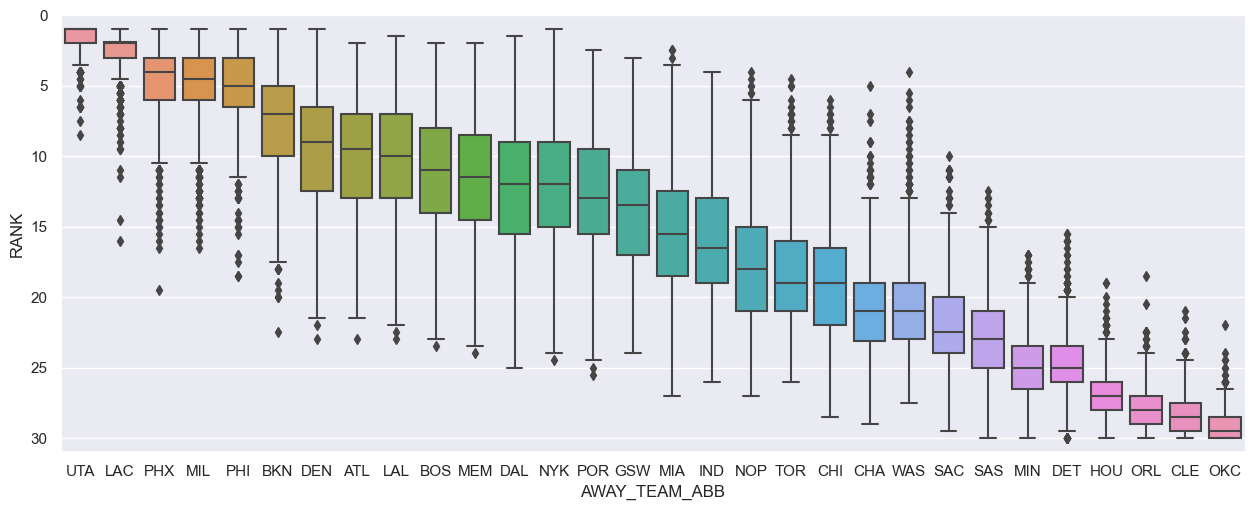

In [1032]:
# Find the order
my_order = performance.groupby('AWAY_TEAM_ABB')["RANK"].median().sort_values().index
chart = sns.catplot(data=performance, x='AWAY_TEAM_ABB', y='RANK', order=my_order, kind='box', aspect=2.5, sharex=False)

# edit axes
plt.ylim(0, 31)
plt.gca().invert_yaxis()

plt.show()

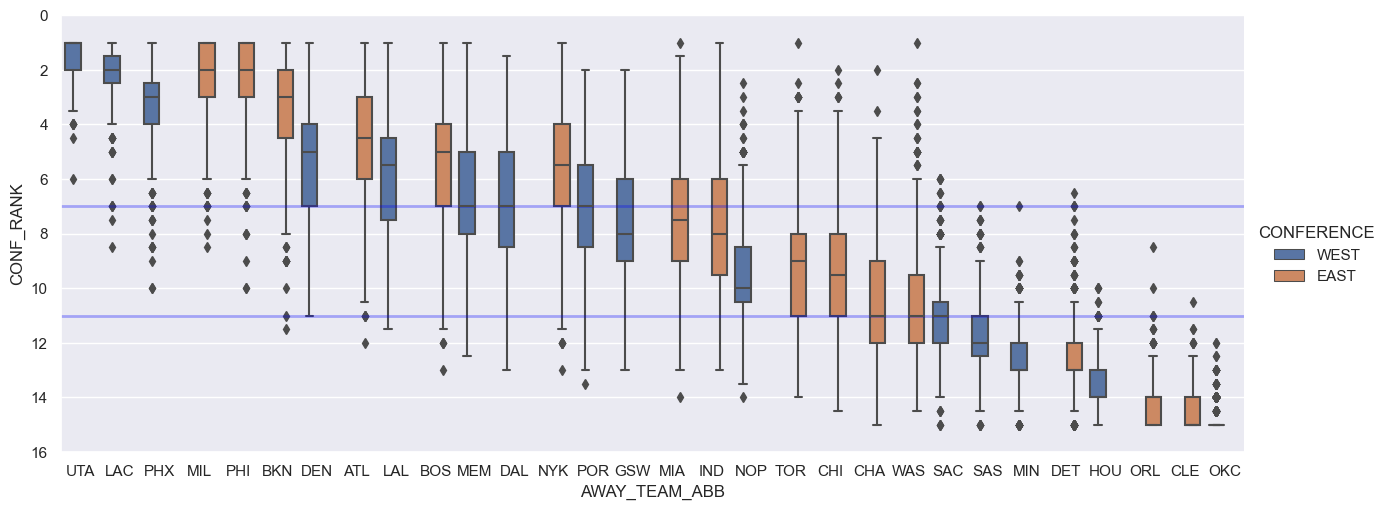

In [1033]:
# Find the order
my_order = performance.groupby('AWAY_TEAM_ABB')["RANK"].median().sort_values().index
chart = sns.catplot(data=performance, x='AWAY_TEAM_ABB', y='CONF_RANK', hue='CONFERENCE', order=my_order, kind='box', aspect=2.5, sharex=False)

# edit axes
plt.ylim(0, 16)
plt.gca().invert_yaxis()

# play-in
chart.axes[0][0].axhline(y = 7, color='blue', linewidth=2, alpha=.3)
#chart.axes[1][0].axhline(y = 7, color='blue', linewidth=2, alpha=.3)

chart.axes[0][0].axhline(y = 11, color='blue', linewidth=2, alpha=.3)
#chart.axes[1][0].axhline(y = 11, color='blue', linewidth=2, alpha=.3)

plt.show()

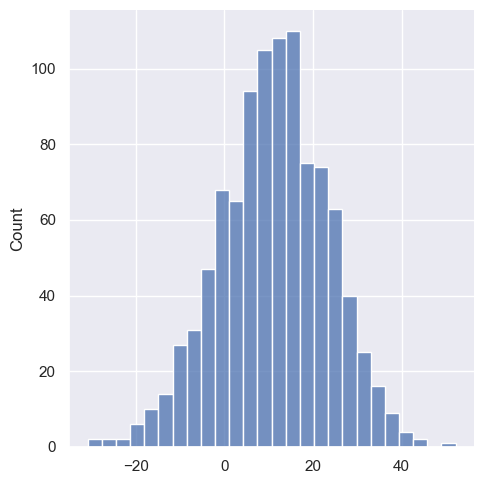

In [1034]:
sns.displot(season_sim[1000, :])
plt.show()

In [1035]:
def create_scoreboard(df_int_test, prediction, prediction_trade):
    """ creates wins and ranks teams
    """
    
    # insert prediction of PM
    df_int_test['Prediction_PM'] = prediction
    df_int_test['Prediction_Trade_PM'] = prediction_trade

    # count out wins from home and away
    df_int_test['WIN_HOME'] = np.where(df_int_test['PLUS_MINUS_y'] > 0, 1, 0)
    df_int_test['WIN_AWAY'] = np.where(df_int_test['PLUS_MINUS_y'] > 0, 0, 1)

    df_int_test['WIN_HOME_pred'] = np.where(df_int_test['Prediction_PM'] > 0, 1, 0)
    df_int_test['WIN_AWAY_pred'] = np.where(df_int_test['Prediction_PM'] > 0, 0, 1)

    df_int_test['WIN_HOME_trade'] = np.where(df_int_test['Prediction_Trade_PM'] > 0, 1, 0)
    df_int_test['WIN_AWAY_trade'] = np.where(df_int_test['Prediction_Trade_PM'] > 0, 0, 1)
    
    # season performance from home and away perspective
    season_performance_home = df_int_test.groupby(['SEASON_ID_x', 'HOME_TEAM_ABB'])[['WIN_HOME', 'WIN_HOME_pred', 'WIN_HOME_trade']].sum()
    season_performance_away = df_int_test.groupby(['SEASON_ID_x', 'AWAY_TEAM_ABB'])[['WIN_AWAY', 'WIN_AWAY_pred', 'WIN_AWAY_trade']].sum()
    season_performance_home.reset_index(inplace=True)
    season_performance_away.reset_index(inplace=True)
    
    # merge together based on teams
    season_performance_tmp = pd.merge(season_performance_home, season_performance_away, left_on=['SEASON_ID_x', 'HOME_TEAM_ABB'], right_on=['SEASON_ID_x', 'AWAY_TEAM_ABB'])

    # add up home and away for the total
    season_performance_tmp['WIN'] = season_performance_tmp['WIN_HOME'] + season_performance_tmp['WIN_AWAY']
    season_performance_tmp['WIN_pred'] = season_performance_tmp['WIN_HOME_pred'] + season_performance_tmp['WIN_AWAY_pred']
    season_performance_tmp['WIN_trade'] = season_performance_tmp['WIN_HOME_trade'] + season_performance_tmp['WIN_AWAY_trade']
    season_performance_tmp['TEAM_ABBREVIATION'] = season_performance_tmp['HOME_TEAM_ABB']
    
    # compute the predicted change due to trade
    season_performance_tmp['TRADE_CHANGE'] = season_performance_tmp['WIN_trade'] - season_performance_tmp['WIN_pred']
    
    # cosmetics
    season_performance = season_performance_tmp.drop(['HOME_TEAM_ABB', 'AWAY_TEAM_ABB', 'WIN_HOME', 'WIN_HOME_pred', 'WIN_HOME_trade', 'WIN_AWAY', 'WIN_AWAY_pred', 'WIN_AWAY_trade'], axis=1)
    season_performance = season_performance.rename(columns={'SEASON_ID_x':'SEASON_ID'})
    
    # rankings
    season_performance['RANK'] = season_performance['WIN'].astype(int).rank(ascending=False)
    season_performance['RANK_pred'] = season_performance['WIN_pred'].astype(int).rank(ascending=False)
    season_performance['RANK_trade'] = season_performance['WIN_trade'].astype(int).rank(ascending=False)

    # order after rank
    season_performance = season_performance.sort_values(['SEASON_ID', 'RANK_pred'], ascending=True)
    
    return season_performance

In [1037]:
import warnings
warnings.filterwarnings("ignore")

# simulate a season
one_season = simulate_one_season(mean_predicted=mean_plus_minus_pred, sigma_predicted=sigma_plus_minus_pred, n_sim=10000, all_games=False)

# create and show its scoreboard
scoreboard = create_scoreboard(df_int_test, mean_plus_minus_pred, mean_plus_minus_trade)
scoreboard

,SEASON_ID,WIN,WIN_pred,WIN_trade,TEAM_ABBREVIATION,TRADE_CHANGE,RANK,RANK_pred,RANK_trade
28,22020,52,69,69,UTA,0,1.0,1.0,1.0
12,22020,47,65,65,LAC,0,5.0,2.0,2.0
23,22020,51,59,60,PHX,1,2.0,3.0,3.0
16,22020,46,58,58,MIL,0,7.0,4.5,4.5
22,22020,49,58,58,PHI,0,3.0,4.5,4.5
1,22020,47,56,56,BKN,0,5.0,6.0,6.0
14,22020,38,48,48,MEM,0,15.0,7.0,7.0
0,22020,41,47,47,ATL,0,11.5,8.0,8.0
2,22020,36,46,46,BOS,0,16.0,9.5,9.5
13,22020,42,46,44,LAL,-2,9.0,9.5,12.5


In [994]:
scoreboard = pd.merge(scoreboard, team_conference)

west = scoreboard[scoreboard['CONFERENCE'] == 'WEST']
east = scoreboard[scoreboard['CONFERENCE'] == 'EAST']

west['RANK_CONF'] = west['RANK'].rank(ascending=True)
east['RANK_CONF'] = east['RANK'].rank(ascending=True)

west = west.sort_values("RANK_CONF")
east = east.sort_values("RANK_CONF")

In [863]:
away_court = playoff['TEAM_ABBREVIATION'][4:8]
home_court = playoff['TEAM_ABBREVIATION'][:4]

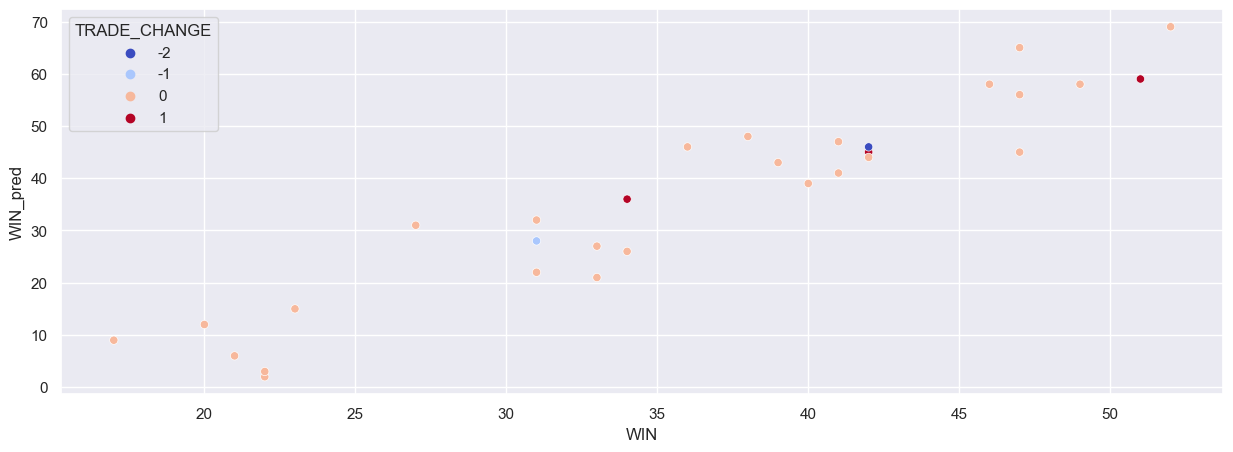

In [999]:
sns.scatterplot(data=season_performance, x="WIN", y="WIN_pred", hue="TRADE_CHANGE", palette='coolwarm')
plt.show()

In [1000]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# estimate ridge
ridge = Ridge(alpha=1e-3)
ridge.fit(X_train, y_train)

# estimate OLS
ols = LinearRegression()
ols.fit(X_train, y_train)

# estiamte RF
regr = RandomForestRegressor(max_depth=20, random_state=0, oob_score=True, n_estimators=200)
regr.fit(X_train, y_train)

# test set scores
pred_rf = regr.predict(X_test)
pred_ols = ols.predict(X_test)
pred_ridge = ridge.predict(X_test)

trade_ols = ols.predict(X_trade)

ridge.score(X, y)
regr.score(X, y)

0.5231587935182311

In [1001]:
trade_ols

array([-1.61888707,  1.45972507,  7.39245643, ..., -6.21228015,
       -3.79153824,  7.86319873])

In [88]:
df_coef = pd.DataFrame({'Coef':ols.coef_,'Feature':features_names})
df_coef.sort_values(['Feature'])

,Coef,Feature
13,1.162357,BENCH_DEPTH_AWAY
6,0.380692,BENCH_DEPTH_HOME
11,-1.140776,CENTER_AWAY_1
4,0.590233,CENTER_HOME_1
9,-1.009055,FORWARD_AWAY_1
10,-0.637083,FORWARD_AWAY_2
2,0.964359,FORWARD_HOME_1
3,0.970601,FORWARD_HOME_2
7,-0.757714,GUARD_AWAY_1
8,-0.817910,GUARD_AWAY_2


In [89]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred_rf, y_test), mean_absolute_error(pred_ols, y_test), mean_absolute_error(pred_ridge, y_test)

(10.775789064476921, 10.557177339499964, 10.557176430068411)

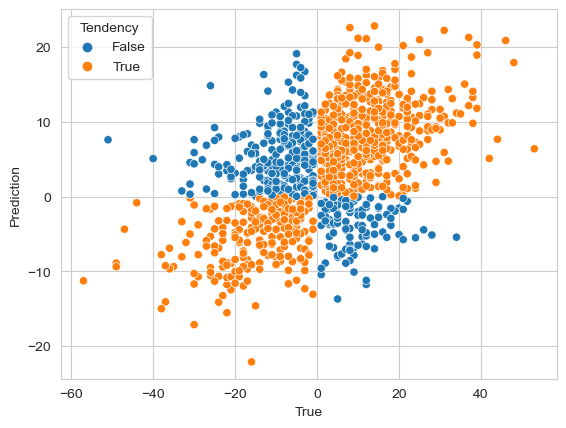

	 	 	 Tendency correct for 65.99 %


In [90]:
plot_data = pd.DataFrame(data={'True':y_test, 'Prediction':pred_ols})
plot_data['Tendency'] = plot_data['True'] * plot_data['Prediction'] > 0
sns.set_style("whitegrid")
sns.scatterplot(data=plot_data, x='True', y='Prediction', hue='Tendency')
plt.show()
print(f'\t \t \t Tendency correct for {np.round(np.mean(plot_data.Tendency) * 100, 2)} %')

For 1:2 split, it is up to 70% i.e. need more data probably

In [855]:
season_prediction = df_int_test.copy()
season_prediction.loc[:, 'pred'] = pred_ols
season_prediction.loc[:, 'y_true'] = y_test

season_prediction['pred_win'] = season_prediction['pred'] > 0
season_prediction['true_win'] = season_prediction['PLUS_MINUS_y'] > 0

season_prediction['pred_eq_true'] = season_prediction['pred_win'] == season_prediction['true_win']

In [856]:
season_prediction['pred_eq_true'].mean()

0.659870250231696

In [848]:
from sklearn.metrics import accuracy_score
accuracy_score(season_prediction['true_win'], season_prediction['pred_win'])

0.659870250231696

In [857]:
season_prediction

,Unnamed: 0,Unnamed: 0.1,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,FORWARD_AWAY_2,CENTER_AWAY_1,SIXTH_AWAY_1,BENCH_DEPTH_AWAY,PLUS_MINUS_y,pred,y_true,pred_win,true_win,pred_eq_true
2121,3,3,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,L,...,2.04,0.45,0.018889,10.0,-7.0,0.923053,-7.0,True,False,False
2122,4,4,22020,1610612738,BOS,Boston Celtics,22000003,2020-12-23,BOS vs. MIL,W,...,2.17,1.63,-0.036000,11.0,1.0,2.741763,1.0,True,True,True
2124,18,18,22020,1610612756,PHX,Phoenix Suns,22000004,2020-12-23,PHX vs. DAL,W,...,1.81,1.29,0.081111,10.0,4.0,9.040516,4.0,True,True,True
2126,28,28,22020,1610612748,MIA,Miami Heat,22000005,2020-12-25,MIA vs. NOP,W,...,1.48,0.68,-0.037778,10.0,13.0,4.939564,13.0,True,True,True
2129,31,31,22020,1610612749,MIL,Milwaukee Bucks,22000006,2020-12-25,MIL vs. GSW,W,...,-1.11,-2.41,0.441250,9.0,39.0,11.803515,39.0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4268,2142,2142,22020,1610612757,POR,Portland Trail Blazers,22001076,2021-05-16,POR vs. DEN,W,...,1.12,1.77,-0.524444,10.0,16.0,6.181909,16.0,True,True,True
4270,2148,2148,22020,1610612758,SAC,Sacramento Kings,22001077,2021-05-16,SAC vs. UTA,L,...,3.03,4.51,-0.307000,11.0,-22.0,-9.182961,-22.0,False,False,True
4273,2135,2135,22020,1610612759,SAS,San Antonio Spurs,22001078,2021-05-16,SAS vs. PHX,L,...,-0.27,2.30,0.253750,9.0,-2.0,-7.824448,-2.0,False,False,True
4275,2155,2155,22020,1610612761,TOR,Toronto Raptors,22001079,2021-05-16,TOR vs. IND,L,...,0.89,-0.52,0.430000,8.0,-12.0,-4.289650,-12.0,False,False,True


In [865]:
tmp = pd.DataFrame(season_prediction.groupby('TEAM_ID')['pred_win'].sum()).reset_index()
tmp2 = pd.DataFrame(season_prediction.groupby('TEAM_ID')['true_win'].sum()).reset_index()

predicted_season = pd.merge(tmp, tmp2)

In [874]:
predicted_season.sort_values(['true_win'], ascending=False, ignore_index=True)['order']

,index,TEAM_ID,pred_win,true_win
0,0,1610612762,36,31
1,1,1610612755,35,29
2,2,1610612756,34,27
3,3,1610612751,31,27
4,4,1610612746,35,26
5,5,1610612749,34,26
6,6,1610612737,32,25
7,7,1610612752,30,25
8,8,1610612744,28,25
9,9,1610612743,31,25


> Modelbaum Playoffs simulieren, step-by-step, Turnierbaum, Probabilistic für Series Simulation

In [2]:
data = pd.read_csv("preprocessing.csv", dtype={'GAME_ID':str})

In [4]:
data['GAME_ID']

0                   0
1                   0
2                   0
3                   0
4                   0
              ...    
1536732    0022001072
1536733    0022001072
1536734    0022001072
1536735    0022001072
1536736    0022001072
Name: GAME_ID, Length: 1536737, dtype: object

In [5]:
import time
from tqdm import tqdm
from nba_api.stats.endpoints import boxscoreadvancedv2
def get_roster_and_starters(data):

    list_starters = list()
    list_roster = list()

    print(data.head())

    unique_games = data['GAME_ID'].unique()

    print(unique_games)

    for gameid in tqdm(unique_games):
            print(gameid)
            try:
                call_boxscore = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=gameid)
                game = pd.concat(call_boxscore.get_data_frames())

                # get home or away
                print(game['TEAM_ID'].unique())
                away_team_id = game['TEAM_ID'].unique()[0] # maybe replace by table that has TEAM_LOCATION for all games

                game['TEAM_LOCATION'] = np.where(game['TEAM_ID'] == away_team_id, 'AWAY', 'HOME')


                tmp2 = game[~game['START_POSITION'].isna()][['START_POSITION', 'PLAYER_ID', 'GAME_ID', 'TEAM_ID', 'TEAM_LOCATION']]
                tmp2['STARTER'] = np.where((tmp2['START_POSITION'] == ""), False, True)
                tmp2 = tmp2.drop_duplicates()  # just in case

                list_starters.append(tmp2[tmp2['STARTER']])
                list_roster.append(tmp2)

                time.sleep(0.75)
            
            except:
                print(f'ID {gameid} got skipped')
                next

    return pd.concat(list_starters), pd.concat(list_roster)

def get_all_subs(data):
    bool_sub = data['EVENTMSGTYPE'] == 8
    subs = data.loc[bool_sub, ['GAME_ID', 'stint', 'game_time_left', 'TEAM_LOCATION', 'PLAYER1_ID', 'PLAYER2_ID']]
    subs = subs.rename(columns={'PLAYER1_ID':'PLAYER_OUT_ID', 'PLAYER2_ID':'PLAYER_IN_ID'})
    return subs.sort_values(['GAME_ID', 'stint'])

def get_starting_lineup(starters):

    tmp = starters.groupby(['GAME_ID', 'TEAM_ID'])['PLAYER_ID'].unique().reset_index()
    starting_lineup = tmp.explode('PLAYER_ID')
    starting_lineup['stint'] = 0

    return starting_lineup

from tqdm import tqdm
def get_on_court(data, starters, sub):

    # init
    game_ids = data['GAME_ID'].unique()
    list_on_court = list()
    list_game_id = list()
    list_stint = list()

    # loop over all games
    for game_id in tqdm(game_ids):

        # form subsets
        game = data[data['GAME_ID'] == game_id]
        starting_lineup = starters[starters['GAME_ID'] == game_id]
        subs = sub[sub['GAME_ID'] == game_id]

        # prepare stints for the loop
        a = game['stint_marker'].unique()
        tmp = a[~np.isnan(a)]
        last_stint = np.max(tmp)
        stints = tmp - 1

        # get rosters for the game for both teams
        starters_home = starting_lineup[starting_lineup['TEAM_LOCATION'] == "HOME"]['PLAYER_ID'].unique()
        starters_away = starting_lineup[starting_lineup['TEAM_LOCATION'] == "AWAY"]['PLAYER_ID'].unique()

        # get the substitutions
        players_in, players_out = subs['PLAYER_IN_ID'].values, subs['PLAYER_OUT_ID'].values

        # more init
        on_court = np.zeros((stints.shape[0]+1, 10))
        lineup = np.append(starters_home, starters_away)

        # store game id, so lengths match
        list_game_id.append(game_id)

        for i, stint in enumerate(stints):

            j = i+1

            # for first iteration store starting lineup and first sub
            if stint == 0:
                on_court[i, :] = lineup
                lineup[lineup == players_out[i]] = players_in[i] # sub player out
                on_court[j, :] = lineup

            else:
                lineup[lineup == players_out[i]] = players_in[i]
                on_court[j, :] = lineup

            # store and keep track
            list_game_id.append(game_id)
            list_stint.append(stint)

        # store on court formations
        list_on_court.append(on_court)
        list_stint.append(last_stint)

        # numpy format
        a_on_court = np.concatenate(list_on_court)
        a_game_id = np.asarray(list_game_id)
        a_stint = np.asarray(list_stint)

        # create colnames
        col_names = ['stint']
        col_names.extend([f'HOME_{i}' for i in np.arange(start=1, stop=6)])
        col_names.extend([f'AWAY_{i}' for i in np.arange(start=1, stop=6)])
        col_names.extend(['GAME_ID'])

        # transform to dataframe
        df = pd.DataFrame(data=np.concatenate((a_stint.reshape(-1, 1), a_on_court,
                                               a_game_id.reshape(-1, 1)), axis=1), columns=col_names)

        # adjust datatype
        df['stint'] = df['stint'].astype(float)

    return df

In [ ]:
# get starters and roster
starters, roster = get_roster_and_starters(data)

# get starting lineups, subs and on court players
#starting_lineups = get_starting_lineup(starters)
#subs = get_all_subs(data=data)
#court = get_on_court(data=data, starters=starters, sub=subs)

  0%|          | 0/3363 [00:00<?, ?it/s]

   Unnamed: 0  Unnamed: 0.1 GAME_ID  EVENTNUM  EVENTMSGTYPE  \
0           0             0       0       0.0             0   
1           1             0       0       0.0             0   
2           2             0       0       0.0             0   
3           3             0       0       0.0             0   
4           4             0       0       0.0             0   

   EVENTMSGACTIONTYPE  PERIOD HOMEDESCRIPTION VISITORDESCRIPTION SCORE  ...  \
0                 0.0     0.0               0                  0     0  ...   
1                 0.0     0.0               0                  0     0  ...   
2                 0.0     0.0               0                  0     0  ...   
3                 0.0     0.0               0                  0     0  ...   
4                 0.0     0.0               0                  0     0  ...   

   EVENT  POSS_CHANGE AWAY_POSS  HOME_POSS  HOME_PTS  AWAY_PTS HOME_PM  \
0  OTHER          0.0       NaN        NaN       NaN       NaN     NaN  

  0%|          | 1/3363 [00:00<29:11,  1.92it/s]

ID 0 got skipped
0021800002
[1610612760 1610612744]


  0%|          | 2/3363 [00:01<49:06,  1.14it/s]

0021800001
[1610612755 1610612738]


  0%|          | 3/3363 [00:02<55:05,  1.02it/s]

0021800010
[1610612750 1610612759]


  0%|          | 4/3363 [00:03<59:13,  1.06s/it]

0021800007
[1610612737 1610612752]


  0%|          | 5/3363 [00:05<1:00:55,  1.09s/it]

0021800013
[1610612742 1610612756]


  0%|          | 6/3363 [00:06<1:01:37,  1.10s/it]

0021800012
[1610612743 1610612746]


  0%|          | 7/3363 [00:07<1:01:55,  1.11s/it]

0021800006
[1610612748 1610612753]


  0%|          | 8/3363 [00:08<1:02:25,  1.12s/it]

0021800009
[1610612740 1610612745]


  0%|          | 9/3363 [00:09<1:02:48,  1.12s/it]

0021800004
[1610612751 1610612765]


  0%|          | 10/3363 [00:10<1:02:16,  1.11s/it]

0021800005
[1610612763 1610612754]


  0%|          | 11/3363 [00:11<1:02:04,  1.11s/it]

0021800011
[1610612762 1610612758]


  0%|          | 12/3363 [00:12<1:01:55,  1.11s/it]

0021800003
[1610612749 1610612766]


  0%|          | 13/3363 [00:14<1:02:59,  1.13s/it]

0021800008
[1610612739 1610612761]


  0%|          | 14/3363 [00:15<1:02:43,  1.12s/it]

0021800014
[1610612741 1610612755]


  0%|          | 15/3363 [00:16<1:02:45,  1.12s/it]

0021800016
[1610612747 1610612757]


  0%|          | 16/3363 [00:17<1:02:13,  1.12s/it]

0021800015
[1610612748 1610612764]


  1%|          | 17/3363 [00:18<1:02:32,  1.12s/it]

0021800018
[1610612752 1610612751]


  1%|          | 18/3363 [00:19<1:02:31,  1.12s/it]

0021800025
[1610612760 1610612746]


  1%|          | 19/3363 [00:20<58:28,  1.05s/it]  

ID 0021800025 got skipped
0021800017
[1610612766 1610612753]


  1%|          | 20/3363 [00:21<1:00:29,  1.09s/it]

0021800023
[1610612754 1610612749]


  1%|          | 21/3363 [00:22<1:01:01,  1.10s/it]

0021800024
[1610612744 1610612762]


  1%|          | 22/3363 [00:23<1:01:15,  1.10s/it]

ID 0021800024 got skipped
0021800021
[1610612739 1610612750]


  1%|          | 23/3363 [00:25<1:02:26,  1.12s/it]

0021800019
[1610612738 1610612761]


  1%|          | 24/3363 [00:26<1:03:00,  1.13s/it]

0021800020
[1610612737 1610612763]


  1%|          | 25/3363 [00:27<1:02:50,  1.13s/it]

0021800022
[1610612758 1610612740]


  1%|          | 26/3363 [00:28<1:03:58,  1.15s/it]

0021800029
[1610612753 1610612755]


  1%|          | 27/3363 [00:29<1:04:49,  1.17s/it]

0021800035
[1610612745 1610612747]


  1%|          | 28/3363 [00:31<1:05:38,  1.18s/it]

0021800031
[1610612765 1610612741]


  1%|          | 29/3363 [00:32<1:04:02,  1.15s/it]

0021800028
[1610612738 1610612752]


  1%|          | 30/3363 [00:33<1:03:42,  1.15s/it]

0021800030
[1610612766 1610612748]


  1%|          | 31/3363 [00:34<1:03:10,  1.14s/it]

0021800034
[1610612759 1610612757]


  1%|          | 32/3363 [00:35<1:02:48,  1.13s/it]

0021800026
[1610612751 1610612754]


  1%|          | 33/3363 [00:36<1:02:26,  1.13s/it]

0021800032
[1610612750 1610612742]


  1%|          | 34/3363 [00:37<1:04:00,  1.15s/it]

0021800033
[1610612756 1610612743]


  1%|          | 35/3363 [00:38<1:03:30,  1.15s/it]

0021800027
[1610612761 1610612764]


  1%|          | 36/3363 [00:40<1:03:09,  1.14s/it]

0021800039
[1610612745 1610612746]


  1%|          | 37/3363 [00:41<1:02:58,  1.14s/it]

0021800036
[1610612737 1610612739]


  1%|          | 38/3363 [00:42<1:02:46,  1.13s/it]

0021800038
[1610612744 1610612743]


  1%|          | 39/3363 [00:43<1:02:16,  1.12s/it]

0021800037
[1610612758 1610612760]


  1%|          | 40/3363 [00:44<1:02:36,  1.13s/it]

0021800047
[1610612756 1610612744]


  1%|          | 41/3363 [00:45<1:03:35,  1.15s/it]

0021800048
[1610612759 1610612747]


  1%|          | 42/3363 [00:46<1:03:36,  1.15s/it]

0021800040
[1610612753 1610612738]


  1%|▏         | 43/3363 [00:48<1:03:03,  1.14s/it]

0021800046
[1610612764 1610612757]


  1%|▏         | 44/3363 [00:49<1:02:33,  1.13s/it]

0021800042
[1610612752 1610612749]


  1%|▏         | 45/3363 [00:50<1:02:34,  1.13s/it]

0021800045
[1610612763 1610612762]


  1%|▏         | 46/3363 [00:51<1:02:27,  1.13s/it]

0021800044
[1610612741 1610612742]


  1%|▏         | 47/3363 [00:52<1:01:59,  1.12s/it]

0021800043
[1610612754 1610612750]


  1%|▏         | 48/3363 [00:53<1:02:02,  1.12s/it]

0021800041
[1610612766 1610612761]


  1%|▏         | 49/3363 [00:54<1:02:00,  1.12s/it]

0021800049
[1610612755 1610612765]


  1%|▏         | 50/3363 [00:55<1:03:43,  1.15s/it]

0021800051
[1610612758 1610612743]


  2%|▏         | 51/3363 [00:57<1:03:07,  1.14s/it]

0021800050
[1610612746 1610612740]


  2%|▏         | 52/3363 [00:58<1:02:44,  1.14s/it]

0021800062
[1610612764 1610612744]


  2%|▏         | 53/3363 [00:59<1:02:29,  1.13s/it]

0021800058
[1610612754 1610612759]


  2%|▏         | 54/3363 [01:00<1:02:22,  1.13s/it]

0021800056
[1610612766 1610612741]


  2%|▏         | 55/3363 [01:01<1:03:05,  1.14s/it]

0021800060
[1610612747 1610612756]


  2%|▏         | 56/3363 [01:02<1:02:32,  1.13s/it]

0021800057
[1610612762 1610612745]


  2%|▏         | 57/3363 [01:03<1:02:20,  1.13s/it]

0021800053
[1610612751 1610612739]


  2%|▏         | 58/3363 [01:04<1:02:02,  1.13s/it]

0021800054
[1610612752 1610612748]


  2%|▏         | 59/3363 [01:06<1:02:57,  1.14s/it]

0021800059
[1610612755 1610612749]


  2%|▏         | 60/3363 [01:07<1:04:52,  1.18s/it]

0021800052
[1610612742 1610612737]


  2%|▏         | 61/3363 [01:08<1:03:42,  1.16s/it]

0021800061
[1610612763 1610612758]


  2%|▏         | 62/3363 [01:09<1:03:00,  1.15s/it]

0021800055
[1610612750 1610612761]


  2%|▏         | 63/3363 [01:10<1:03:07,  1.15s/it]

0021800066
[1610612743 1610612747]


  2%|▏         | 64/3363 [01:11<1:02:17,  1.13s/it]

0021800064
[1610612757 1610612753]


  2%|▏         | 65/3363 [01:13<1:03:53,  1.16s/it]

0021800063
[1610612739 1610612765]


  2%|▏         | 66/3363 [01:14<1:02:55,  1.15s/it]

0021800065
[1610612738 1610612760]


  2%|▏         | 67/3363 [01:15<1:02:14,  1.13s/it]

0021800068
[1610612744 1610612752]


  2%|▏         | 68/3363 [01:16<1:02:06,  1.13s/it]

0021800070
[1610612746 1610612745]


  2%|▏         | 69/3363 [01:17<1:03:16,  1.15s/it]

0021800073
[1610612764 1610612758]


  2%|▏         | 70/3363 [01:18<1:02:50,  1.14s/it]

0021800071
[1610612749 1610612750]


  2%|▏         | 71/3363 [01:19<1:02:26,  1.14s/it]

0021800067
[1610612741 1610612766]


  2%|▏         | 72/3363 [01:21<1:01:59,  1.13s/it]

0021800069
[1610612742 1610612761]


  2%|▏         | 73/3363 [01:22<1:01:52,  1.13s/it]

0021800072
[1610612751 1610612740]


  2%|▏         | 74/3363 [01:23<1:03:35,  1.16s/it]

0021800078
[1610612766 1610612755]


  2%|▏         | 75/3363 [01:24<1:03:11,  1.15s/it]

0021800082
[1610612747 1610612759]


  2%|▏         | 76/3363 [01:26<1:09:18,  1.27s/it]

0021800077
[1610612754 1610612739]


  2%|▏         | 77/3363 [01:27<1:08:37,  1.25s/it]

0021800079
[1610612757 1610612748]


  2%|▏         | 78/3363 [01:28<1:06:30,  1.21s/it]

0021800074
[1610612738 1610612765]


  2%|▏         | 79/3363 [01:29<1:05:55,  1.20s/it]

0021800081
[1610612753 1610612749]


  2%|▏         | 80/3363 [01:30<1:04:13,  1.17s/it]

0021800076
[1610612741 1610612737]


  2%|▏         | 81/3363 [01:31<1:03:41,  1.16s/it]

0021800080
[1610612756 1610612763]


  2%|▏         | 82/3363 [01:32<1:03:09,  1.16s/it]

0021800075
[1610612762 1610612740]


  2%|▏         | 83/3363 [01:34<1:01:58,  1.13s/it]

0021800083
[1610612744 1610612751]


  2%|▏         | 84/3363 [01:35<1:01:39,  1.13s/it]

0021800086
[1610612764 1610612746]


  3%|▎         | 85/3363 [01:36<1:01:42,  1.13s/it]

0021800084
[1610612762 1610612742]


  3%|▎         | 86/3363 [01:37<1:01:26,  1.12s/it]

0021800085
[1610612756 1610612760]


  3%|▎         | 87/3363 [01:38<1:00:51,  1.11s/it]

0021800088
[1610612737 1610612755]


  3%|▎         | 88/3363 [01:39<1:01:43,  1.13s/it]

0021800094
[1610612742 1610612759]


  3%|▎         | 89/3363 [01:40<1:01:03,  1.12s/it]

0021800091
[1610612744 1610612741]


  3%|▎         | 90/3363 [01:41<1:02:15,  1.14s/it]

0021800090
[1610612751 1610612752]


  3%|▎         | 91/3363 [01:43<1:01:25,  1.13s/it]

0021800089
[1610612758 1610612748]


  3%|▎         | 92/3363 [01:44<1:01:28,  1.13s/it]

0021800092
[1610612761 1610612749]


  3%|▎         | 93/3363 [01:45<1:01:43,  1.13s/it]

0021800087
[1610612757 1610612754]


  3%|▎         | 94/3363 [01:46<1:04:43,  1.19s/it]

0021800095
[1610612740 1610612743]


  3%|▎         | 95/3363 [01:47<1:03:19,  1.16s/it]

0021800093
[1610612747 1610612750]


  3%|▎         | 96/3363 [01:48<1:01:47,  1.13s/it]

0021800099
[1610612765 1610612738]


  3%|▎         | 97/3363 [01:49<1:01:42,  1.13s/it]

0021800098
[1610612758 1610612753]


  3%|▎         | 98/3363 [01:51<1:01:13,  1.13s/it]

0021800101
[1610612757 1610612745]


  3%|▎         | 99/3363 [01:52<1:01:01,  1.12s/it]

0021800097
[1610612737 1610612739]


  3%|▎         | 100/3363 [01:53<1:00:39,  1.12s/it]

0021800096
[1610612748 1610612766]


  3%|▎         | 101/3363 [01:54<1:00:50,  1.12s/it]

0021800100
[1610612755 1610612761]


  3%|▎         | 102/3363 [01:55<59:28,  1.09s/it]  

0021800102
[1610612764 1610612763]


  3%|▎         | 103/3363 [01:56<59:16,  1.09s/it]

0021800103
[1610612746 1610612760]


  3%|▎         | 104/3363 [01:57<59:41,  1.10s/it]

0021800108
[1610612740 1610612744]


  3%|▎         | 105/3363 [01:58<59:16,  1.09s/it]

0021800109
[1610612742 1610612747]


  3%|▎         | 106/3363 [01:59<59:22,  1.09s/it]

0021800106
[1610612743 1610612741]


  3%|▎         | 107/3363 [02:00<59:19,  1.09s/it]

0021800105
[1610612754 1610612752]


  3%|▎         | 108/3363 [02:01<59:15,  1.09s/it]

0021800110
[1610612759 1610612756]


  3%|▎         | 109/3363 [02:03<59:45,  1.10s/it]

0021800104
[1610612765 1610612751]


  3%|▎         | 110/3363 [02:04<59:51,  1.10s/it]

0021800107
[1610612762 1610612750]


  3%|▎         | 111/3363 [02:05<59:53,  1.11s/it]

0021800113
[1610612746 1610612755]


  3%|▎         | 112/3363 [02:06<1:00:46,  1.12s/it]

0021800115
[1610612749 1610612738]


  3%|▎         | 113/3363 [02:07<1:00:45,  1.12s/it]

0021800112
[1610612743 1610612739]


  3%|▎         | 114/3363 [02:08<1:00:15,  1.11s/it]

0021800116
[1610612740 1610612757]


  3%|▎         | 115/3363 [02:09<1:00:04,  1.11s/it]

0021800114
[1610612758 1610612737]


  3%|▎         | 116/3363 [02:10<59:46,  1.10s/it]  

0021800111
[1610612760 1610612766]


  3%|▎         | 117/3363 [02:11<59:44,  1.10s/it]

0021800124
[1610612750 1610612744]


  4%|▎         | 118/3363 [02:13<59:23,  1.10s/it]

0021800120
[1610612754 1610612741]


  4%|▎         | 119/3363 [02:14<59:14,  1.10s/it]

0021800123
[1610612761 1610612756]


  4%|▎         | 120/3363 [02:15<59:23,  1.10s/it]

0021800118
[1610612745 1610612751]


  4%|▎         | 121/3363 [02:16<59:23,  1.10s/it]

0021800117
[1610612746 1610612753]


  4%|▎         | 122/3363 [02:17<1:00:48,  1.13s/it]

0021800122
[1610612763 1610612762]


  4%|▎         | 123/3363 [02:18<1:01:01,  1.13s/it]

0021800121
[1610612752 1610612742]


  4%|▎         | 124/3363 [02:19<1:00:30,  1.12s/it]

0021800119
[1610612760 1610612764]


  4%|▎         | 125/3363 [02:20<1:00:17,  1.12s/it]

0021800125
[1610612765 1610612755]


  4%|▎         | 126/3363 [02:22<1:00:35,  1.12s/it]

0021800130
[1610612740 1610612759]


  4%|▍         | 127/3363 [02:23<1:00:19,  1.12s/it]

0021800129
[1610612745 1610612741]


  4%|▍         | 128/3363 [02:24<59:57,  1.11s/it]  

0021800132
[1610612747 1610612757]


  4%|▍         | 129/3363 [02:25<59:42,  1.11s/it]

0021800127
[1610612738 1610612754]


  4%|▍         | 130/3363 [02:26<59:26,  1.10s/it]

0021800128
[1610612748 1610612737]


  4%|▍         | 131/3363 [02:27<59:15,  1.10s/it]

0021800131
[1610612762 1610612743]


  4%|▍         | 132/3363 [02:28<59:19,  1.10s/it]

0021800126
[1610612739 1610612766]


  4%|▍         | 133/3363 [02:29<59:35,  1.11s/it]

0021800137
[1610612753 1610612759]


  4%|▍         | 134/3363 [02:30<59:19,  1.10s/it]

0021800139
[1610612761 1610612747]


  4%|▍         | 135/3363 [02:31<59:26,  1.10s/it]

0021800136
[1610612763 1610612756]


  4%|▍         | 136/3363 [02:33<59:33,  1.11s/it]

0021800134
[1610612755 1610612751]


  4%|▍         | 137/3363 [02:34<59:42,  1.11s/it]

0021800138
[1610612750 1610612757]


  4%|▍         | 138/3363 [02:35<59:32,  1.11s/it]

0021800133
[1610612758 1610612749]


  4%|▍         | 139/3363 [02:36<59:31,  1.11s/it]

0021800135
[1610612752 1610612764]


  4%|▍         | 140/3363 [02:37<59:33,  1.11s/it]

0021800147
[1610612763 1610612744]


  4%|▍         | 141/3363 [02:38<59:43,  1.11s/it]

0021800143
[1610612741 1610612752]


  4%|▍         | 142/3363 [02:39<1:00:24,  1.13s/it]

0021800148
[1610612750 1610612746]


  4%|▍         | 143/3363 [02:40<59:48,  1.11s/it]  

0021800142
[1610612739 1610612753]


  4%|▍         | 144/3363 [02:42<1:00:50,  1.13s/it]

0021800140
[1610612748 1610612765]


  4%|▍         | 145/3363 [02:43<1:01:02,  1.14s/it]

0021800141
[1610612745 1610612754]


  4%|▍         | 146/3363 [02:44<1:00:13,  1.12s/it]

0021800146
[1610612761 1610612762]


  4%|▍         | 147/3363 [02:45<1:01:57,  1.16s/it]

0021800145
[1610612738 1610612743]


  4%|▍         | 148/3363 [02:46<1:00:43,  1.13s/it]

0021800144
[1610612740 1610612760]


  4%|▍         | 149/3363 [02:47<1:00:19,  1.13s/it]

0021800151
[1610612751 1610612756]


  4%|▍         | 150/3363 [02:48<59:47,  1.12s/it]  

0021800152
[1610612749 1610612757]


  4%|▍         | 151/3363 [02:49<1:00:17,  1.13s/it]

0021800150
[1610612764 1610612742]


  5%|▍         | 152/3363 [02:51<59:34,  1.11s/it]  

0021800149
[1610612737 1610612766]


  5%|▍         | 153/3363 [02:52<1:00:00,  1.12s/it]

0021800162
[1610612750 1610612747]


  5%|▍         | 154/3363 [02:53<1:00:19,  1.13s/it]

0021800154
[1610612765 1610612753]


  5%|▍         | 155/3363 [02:54<1:00:19,  1.13s/it]

0021800153
[1610612760 1610612739]


  5%|▍         | 156/3363 [02:55<59:43,  1.12s/it]  

0021800156
[1610612759 1610612748]


  5%|▍         | 157/3363 [02:56<1:03:27,  1.19s/it]

0021800160
[1610612742 1610612762]


  5%|▍         | 158/3363 [02:58<1:12:53,  1.36s/it]

0021800157
[1610612755 1610612754]


  5%|▍         | 159/3363 [02:59<1:09:35,  1.30s/it]

0021800155
[1610612752 1610612737]


  5%|▍         | 160/3363 [03:00<1:05:59,  1.24s/it]

0021800161
[1610612761 1610612758]


  5%|▍         | 161/3363 [03:02<1:03:45,  1.19s/it]

0021800158
[1610612743 1610612763]


  5%|▍         | 162/3363 [03:03<1:02:31,  1.17s/it]

0021800159
[1610612741 1610612740]


  5%|▍         | 163/3363 [03:04<1:01:21,  1.15s/it]

0021800166
[1610612749 1610612744]


  5%|▍         | 164/3363 [03:05<1:00:29,  1.13s/it]

0021800164
[1610612738 1610612756]


  5%|▍         | 165/3363 [03:06<1:00:31,  1.14s/it]

0021800165
[1610612746 1610612757]


  5%|▍         | 166/3363 [03:07<59:57,  1.13s/it]  

0021800163
[1610612745 1610612760]


  5%|▍         | 167/3363 [03:08<59:08,  1.11s/it]

0021800168
[1610612766 1610612755]


  5%|▍         | 168/3363 [03:09<1:00:44,  1.14s/it]

0021800167
[1610612764 1610612753]


  5%|▌         | 169/3363 [03:11<1:01:24,  1.15s/it]

0021800170
[1610612754 1610612748]


  5%|▌         | 170/3363 [03:12<1:01:01,  1.15s/it]

0021800172
[1610612738 1610612762]


  5%|▌         | 171/3363 [03:13<1:00:18,  1.13s/it]

0021800169
[1610612765 1610612737]


  5%|▌         | 172/3363 [03:14<1:01:22,  1.15s/it]

0021800173
[1610612750 1610612758]


  5%|▌         | 173/3363 [03:15<1:06:43,  1.25s/it]

0021800171
[1610612751 1610612743]


  5%|▌         | 174/3363 [03:17<1:04:12,  1.21s/it]

0021800182
[1610612751 1610612744]


  5%|▌         | 175/3363 [03:18<1:10:54,  1.33s/it]

0021800180
[1610612745 1610612759]


  5%|▌         | 176/3363 [03:19<1:07:30,  1.27s/it]

0021800178
[1610612739 1610612741]


  5%|▌         | 177/3363 [03:20<1:04:31,  1.22s/it]

0021800175
[1610612749 1610612746]


  5%|▌         | 178/3363 [03:21<1:02:32,  1.18s/it]

0021800177
[1610612764 1610612748]


  5%|▌         | 179/3363 [03:23<1:01:47,  1.16s/it]

0021800181
[1610612760 1610612742]


  5%|▌         | 180/3363 [03:24<1:01:19,  1.16s/it]

0021800183
[1610612747 1610612758]


  5%|▌         | 181/3363 [03:25<1:00:23,  1.14s/it]

0021800174
[1610612752 1610612761]


  5%|▌         | 182/3363 [03:26<59:17,  1.12s/it]  

0021800179
[1610612755 1610612763]


  5%|▌         | 183/3363 [03:27<58:42,  1.11s/it]

0021800176
[1610612756 1610612740]


  5%|▌         | 184/3363 [03:28<58:14,  1.10s/it]

0021800189
[1610612737 1610612747]


  6%|▌         | 185/3363 [03:29<58:28,  1.10s/it]

0021800186
[1610612753 1610612752]


  6%|▌         | 186/3363 [03:30<58:02,  1.10s/it]

0021800185
[1610612754 1610612745]


  6%|▌         | 187/3363 [03:31<58:00,  1.10s/it]

0021800184
[1610612766 1610612765]


  6%|▌         | 188/3363 [03:32<57:49,  1.09s/it]

0021800188
[1610612738 1610612757]


  6%|▌         | 189/3363 [03:34<58:48,  1.11s/it]

0021800187
[1610612749 1610612743]


  6%|▌         | 190/3363 [03:35<58:11,  1.10s/it]

0021800193
[1610612742 1610612741]


  6%|▌         | 191/3363 [03:36<57:55,  1.10s/it]

0021800198
[1610612744 1610612746]


  6%|▌         | 192/3363 [03:37<58:16,  1.10s/it]

0021800191
[1610612755 1610612748]


  6%|▌         | 193/3363 [03:38<58:21,  1.10s/it]

0021800197
[1610612759 1610612758]


  6%|▌         | 194/3363 [03:39<59:48,  1.13s/it]

0021800195
[1610612751 1610612750]


  6%|▌         | 195/3363 [03:40<59:41,  1.13s/it]

0021800192
[1610612740 1610612761]


  6%|▌         | 196/3363 [03:42<1:01:09,  1.16s/it]

0021800190
[1610612753 1610612764]


  6%|▌         | 197/3363 [03:43<1:00:36,  1.15s/it]

0021800194
[1610612762 1610612763]


  6%|▌         | 198/3363 [03:44<1:00:00,  1.14s/it]

0021800196
[1610612756 1610612760]


  6%|▌         | 199/3363 [03:45<1:01:58,  1.18s/it]

0021800201
[1610612737 1610612744]


  6%|▌         | 200/3363 [03:46<1:00:44,  1.15s/it]

0021800199
[1610612766 1610612739]


  6%|▌         | 201/3363 [03:47<1:00:06,  1.14s/it]

0021800200
[1610612745 1610612743]


  6%|▌         | 202/3363 [03:48<59:17,  1.13s/it]  

0021800212
[1610612757 1610612747]


  6%|▌         | 203/3363 [03:50<1:01:46,  1.17s/it]

0021800211
[1610612759 1610612756]


  6%|▌         | 204/3363 [03:51<1:00:51,  1.16s/it]

0021800205
[1610612748 1610612751]


  6%|▌         | 205/3363 [03:52<1:00:02,  1.14s/it]

0021800204
[1610612741 1610612738]


  6%|▌         | 206/3363 [03:53<59:37,  1.13s/it]  

0021800202
[1610612755 1610612753]


  6%|▌         | 207/3363 [03:54<59:00,  1.12s/it]

0021800207
[1610612763 1610612749]


  6%|▌         | 208/3363 [03:55<58:11,  1.11s/it]

0021800210
[1610612762 1610612742]


  6%|▌         | 209/3363 [03:56<58:05,  1.10s/it]

0021800208
[1610612740 1610612750]


  6%|▌         | 210/3363 [03:57<58:05,  1.11s/it]

0021800203
[1610612739 1610612764]


  6%|▋         | 211/3363 [03:58<57:51,  1.10s/it]

0021800206
[1610612765 1610612761]


  6%|▋         | 212/3363 [04:00<57:51,  1.10s/it]

0021800209
[1610612752 1610612760]


  6%|▋         | 213/3363 [04:01<57:53,  1.10s/it]

0021800215
[1610612759 1610612746]


  6%|▋         | 214/3363 [04:02<58:59,  1.12s/it]

0021800213
[1610612744 1610612745]


  6%|▋         | 215/3363 [04:03<58:37,  1.12s/it]

0021800214
[1610612737 1610612743]


  6%|▋         | 216/3363 [04:04<59:27,  1.13s/it]

0021800218
[1610612762 1610612755]


  6%|▋         | 217/3363 [04:05<59:08,  1.13s/it]

0021800216
[1610612761 1610612738]


  6%|▋         | 218/3363 [04:06<58:51,  1.12s/it]

0021800223
[1610612741 1610612749]


  7%|▋         | 219/3363 [04:07<58:20,  1.11s/it]

0021800217
[1610612748 1610612754]


  7%|▋         | 220/3363 [04:09<59:10,  1.13s/it]

0021800221
[1610612757 1610612750]


  7%|▋         | 221/3363 [04:10<58:57,  1.13s/it]

0021800219
[1610612751 1610612764]


  7%|▋         | 222/3363 [04:11<58:17,  1.11s/it]

0021800220
[1610612758 1610612763]


  7%|▋         | 223/3363 [04:12<58:03,  1.11s/it]

0021800222
[1610612752 1610612740]


  7%|▋         | 224/3363 [04:13<58:04,  1.11s/it]

0021800230
[1610612761 1610612741]


  7%|▋         | 225/3363 [04:14<57:40,  1.10s/it]

0021800233
[1610612760 1610612756]


  7%|▋         | 226/3363 [04:15<57:28,  1.10s/it]

0021800224
[1610612746 1610612751]


  7%|▋         | 227/3363 [04:16<58:11,  1.11s/it]

0021800229
[1610612762 1610612738]


  7%|▋         | 228/3363 [04:17<57:53,  1.11s/it]

0021800227
[1610612747 1610612753]


  7%|▋         | 229/3363 [04:19<57:44,  1.11s/it]

0021800231
[1610612758 1610612745]


  7%|▋         | 230/3363 [04:20<57:18,  1.10s/it]

0021800226
[1610612737 1610612754]


  7%|▋         | 231/3363 [04:21<57:24,  1.10s/it]

0021800232
[1610612744 1610612742]


  7%|▋         | 232/3363 [04:22<57:20,  1.10s/it]

0021800225
[1610612755 1610612766]


  7%|▋         | 233/3363 [04:23<57:31,  1.10s/it]

0021800228
[1610612743 1610612740]


  7%|▋         | 234/3363 [04:24<57:45,  1.11s/it]

0021800238
[1610612744 1610612759]


  7%|▋         | 235/3363 [04:25<57:25,  1.10s/it]

0021800236
[1610612752 1610612753]


  7%|▋         | 236/3363 [04:26<57:33,  1.10s/it]

0021800235
[1610612747 1610612748]


  7%|▋         | 237/3363 [04:27<58:10,  1.12s/it]

0021800234
[1610612763 1610612750]


  7%|▋         | 238/3363 [04:29<59:35,  1.14s/it]

0021800237
[1610612757 1610612764]


  7%|▋         | 239/3363 [04:30<1:01:50,  1.19s/it]

0021800242
[1610612756 1610612755]


  7%|▋         | 240/3363 [04:31<1:01:52,  1.19s/it]

0021800240
[1610612739 1610612765]


  7%|▋         | 241/3363 [04:32<1:05:07,  1.25s/it]

0021800245
[1610612743 1610612749]


  7%|▋         | 242/3363 [04:34<1:03:32,  1.22s/it]

0021800241
[1610612762 1610612754]


  7%|▋         | 243/3363 [04:36<1:18:29,  1.51s/it]

0021800243
[1610612746 1610612737]


  7%|▋         | 244/3363 [04:37<1:17:14,  1.49s/it]

0021800247
[1610612760 1610612758]


  7%|▋         | 245/3363 [04:39<1:14:08,  1.43s/it]

0021800239
[1610612738 1610612766]


  7%|▋         | 246/3363 [04:40<1:09:24,  1.34s/it]

0021800244
[1610612742 1610612763]


  7%|▋         | 247/3363 [04:41<1:06:19,  1.28s/it]

0021800246
[1610612759 1610612740]


  7%|▋         | 248/3363 [04:42<1:03:42,  1.23s/it]

0021800251
[1610612757 1610612752]


  7%|▋         | 249/3363 [04:43<1:01:58,  1.19s/it]

0021800248
[1610612761 1610612753]


  7%|▋         | 250/3363 [04:44<1:01:14,  1.18s/it]

0021800250
[1610612751 1610612748]


  7%|▋         | 251/3363 [04:45<1:01:30,  1.19s/it]

0021800249
[1610612746 1610612764]


  7%|▋         | 252/3363 [04:46<1:00:01,  1.16s/it]

0021800253
[1610612740 1610612755]


  8%|▊         | 253/3363 [04:48<59:44,  1.15s/it]  

0021800264
[1610612760 1610612744]


  8%|▊         | 254/3363 [04:49<58:52,  1.14s/it]

0021800262
[1610612763 1610612759]


  8%|▊         | 255/3363 [04:50<58:50,  1.14s/it]

0021800257
[1610612756 1610612741]


  8%|▊         | 256/3363 [04:51<59:01,  1.14s/it]

0021800255
[1610612752 1610612738]


  8%|▊         | 257/3363 [04:52<58:10,  1.12s/it]

0021800258
[1610612765 1610612745]


  8%|▊         | 258/3363 [04:53<57:46,  1.12s/it]

0021800256
[1610612747 1610612739]


  8%|▊         | 259/3363 [04:54<57:14,  1.11s/it]

0021800259
[1610612757 1610612749]


  8%|▊         | 260/3363 [04:55<56:39,  1.10s/it]

0021800263
[1610612758 1610612762]


  8%|▊         | 261/3363 [04:56<56:57,  1.10s/it]

0021800254
[1610612761 1610612737]


  8%|▊         | 262/3363 [04:58<1:01:01,  1.18s/it]

0021800261
[1610612751 1610612742]


  8%|▊         | 263/3363 [04:59<1:01:47,  1.20s/it]

0021800260
[1610612743 1610612750]


  8%|▊         | 264/3363 [05:00<1:00:43,  1.18s/it]

0021800252
[1610612754 1610612766]


  8%|▊         | 265/3363 [05:01<59:35,  1.15s/it]  

0021800270
[1610612739 1610612755]


  8%|▊         | 266/3363 [05:02<59:08,  1.15s/it]

0021800277
[1610612757 1610612744]


  8%|▊         | 267/3363 [05:04<59:24,  1.15s/it]

0021800278
[1610612762 1610612747]


  8%|▊         | 268/3363 [05:05<59:03,  1.14s/it]

0021800273
[1610612748 1610612741]


  8%|▊         | 269/3363 [05:06<58:52,  1.14s/it]

0021800269
[1610612740 1610612752]


  8%|▊         | 270/3363 [05:07<58:24,  1.13s/it]

0021800265
[1610612750 1610612751]


  8%|▊         | 271/3363 [05:08<58:08,  1.13s/it]

0021800266
[1610612763 1610612746]


  8%|▊         | 272/3363 [05:09<57:49,  1.12s/it]

0021800267
[1610612745 1610612765]


  8%|▊         | 273/3363 [05:10<57:24,  1.11s/it]

0021800275
[1610612756 1610612749]


  8%|▊         | 274/3363 [05:11<57:23,  1.11s/it]

0021800272
[1610612759 1610612754]


  8%|▊         | 275/3363 [05:12<57:06,  1.11s/it]

0021800268
[1610612738 1610612737]


  8%|▊         | 276/3363 [05:14<57:18,  1.11s/it]

0021800276
[1610612753 1610612743]


  8%|▊         | 277/3363 [05:15<57:04,  1.11s/it]

0021800271
[1610612764 1610612761]


  8%|▊         | 278/3363 [05:16<57:07,  1.11s/it]

0021800274
[1610612766 1610612760]


  8%|▊         | 279/3363 [05:17<56:32,  1.10s/it]

0021800285
[1610612758 1610612744]


  8%|▊         | 280/3363 [05:18<56:25,  1.10s/it]

0021800279
[1610612745 1610612739]


  8%|▊         | 281/3363 [05:19<56:25,  1.10s/it]

0021800284
[1610612759 1610612749]


  8%|▊         | 282/3363 [05:20<56:19,  1.10s/it]

0021800283
[1610612738 1610612742]


  8%|▊         | 283/3363 [05:21<56:21,  1.10s/it]

0021800281
[1610612741 1610612750]


  8%|▊         | 284/3363 [05:22<56:34,  1.10s/it]

0021800280
[1610612740 1610612764]


  8%|▊         | 285/3363 [05:23<56:20,  1.10s/it]

0021800282
[1610612743 1610612760]


  9%|▊         | 286/3363 [05:25<56:31,  1.10s/it]

0021800286
[1610612753 1610612747]


  9%|▊         | 287/3363 [05:26<58:30,  1.14s/it]

0021800289
[1610612755 1610612751]


  9%|▊         | 288/3363 [05:27<57:50,  1.13s/it]

0021800287


  9%|▊         | 290/3363 [05:27<35:02,  1.46it/s]

ID 0021800287 got skipped
0021800293
ID 0021800293 got skipped
0021800288


  9%|▊         | 291/3363 [05:28<27:24,  1.87it/s]

ID 0021800288 got skipped
0021800292
[1610612762 1610612758]


  9%|▊         | 292/3363 [05:29<36:05,  1.42it/s]

0021800290
[1610612748 1610612761]


  9%|▊         | 293/3363 [05:30<42:55,  1.19it/s]

0021800291
[1610612752 1610612763]


  9%|▊         | 294/3363 [05:31<47:02,  1.09it/s]

0021800300
[1610612753 1610612744]


  9%|▉         | 295/3363 [05:32<50:01,  1.02it/s]

0021800297
[1610612759 1610612741]


  9%|▉         | 296/3363 [05:33<51:44,  1.01s/it]

0021800295
[1610612750 1610612739]


  9%|▉         | 297/3363 [05:34<53:47,  1.05s/it]

0021800299
[1610612754 1610612762]


  9%|▉         | 298/3363 [05:35<54:37,  1.07s/it]

0021800294
[1610612749 1610612766]
